# Milestone 3 - Arcadie

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


## 0. Libraries and path to data 

In [ ]:
# Python library 
import seaborn as sns
from IPython.display import display, HTML
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from matplotlib.gridspec import SubplotSpec
import scipy.stats as stats
import pandas as pd
import numpy as np
import csv
import bz2
import json
import re
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import random

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import mutual_info_classif

# NLP Packages
import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from datetime import datetime
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()
nlp = en_core_web_sm.load()

# Turn of PD warning
pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [ ]:
### Path to dataframe ###

#(Attributes of each quote from Quotebank)
path_to_quotebank = '/content/drive/MyDrive/Quotebank/quotes-2020.json.bz2' 

#(quote_id, speaker_name, quote)
path_to_data_quote = '/content/drive/MyDrive/Data/data_quote.csv'
path_to_data_quote_raw = '/content/drive/MyDrive/Data/data_quote_raw.csv'

#(alias_id = speaker_id, alias)
path_to_id_alias = '/content/drive/MyDrive/Data/id_alias.csv'
path_to_id_alias_cleaned = '/content/drive/MyDrive/Data/id_alias_cleaned.csv'

#(speaker_id, label, list of aliases)
path_to_id_names = '/content/drive/MyDrive/Data/id_names.csv'

#(Attributes of each speaker_id from Wikidata)
path_to_wikidata = '/content/drive/MyDrive/Project_datasets/speaker_attributes.parquet' 
path_to_wikidata_description = '/content/drive/MyDrive/Data/wikidata_labels_descriptions_quotebank.csv'
path_to_labeled_features = '/content/drive/MyDrive/Data/labeled_500.csv'
path_to_degrees_labeled = '/content/drive/MyDrive/Data/degrees_labeled.csv'
path_to_religions_labeled = '/content/drive/MyDrive/Data/religions_labeled.csv'

#(quote_id, speaker_id, mention_id, compound, distance)
path_to_graph = '/content/drive/MyDrive/Data/graph.csv'
path_to_graph_w_labels = '/content/drive/MyDrive/Data/graph_w_labels.csv'
path_to_graph_top_500 = '/content/drive/MyDrive/Data/graph_top_500.csv'

# Saving figures
path_to_figures = '/content/drive/MyDrive/Data/figures/'

#Gephi file and result : year 2020
path_to_graph_gephi = '/content/drive/MyDrive/Data/graph_gephi.csv'
path_to_graph_modularity = '/content/drive/MyDrive/Data/graph_modularity.csv'

#Gephi file and result : years combined 2015-2020
path_to_graph_gephi_all_years = '/content/drive/MyDrive/Data/graph_gephi_all_years.csv'
path_to_graph_modularity_all_years = '/content/drive/MyDrive/Data/path_to_graph_modularity_all_years.csv'

## 1. Create Dataframes and Data Cleaning: data_quote and id_alias_cleaned

### 1.1 Dataframe data_quote

#### 1.1.1 Create data_quote.csv

For creating our social graph we only need the quotes having:
- Speaker
- Someone mentioned in the quote

First we remove all the quote with no speaker assigned (i.e with speaker 'None' assigned).  

The removal of the quotes with no person mentioned will be performed later using SpaCy Named Entity Recognition (NER).

In [ ]:
def parse_json(json_,id):
  person_json={}
  #only the quote where a speaker is identified (different than None) are saved
  if json_['speaker']!="None":
    #only keep the three folowing features : index of quote, name of speaker, and quotation 
    person_json['index']=id
    person_json['speaker']=json_['speaker']
    person_json['quotation']=json_['quotation']
  return person_json

def json_to_csv(json_list, output_csv):
  keys=json_list[0].keys()
  with open(output_csv, 'w', newline='')  as output_file:
    dict_writer = csv.DictWriter(output_file, keys)
    dict_writer.writeheader()
    dict_writer.writerows(json_list)
    
def create_data_quote(quotebank_path, data_quote_save_path, max_entries, new_save = True):
  path_to_file = quotebank_path
  N = max_entries # Size of 2020 is about 3500000. It works but takes some time to load.
  data_quote_list=[]

  with bz2.open(path_to_file, 'rb') as s_file:
    for index, instance in enumerate(s_file):
      if(index < N):
        if index%1000000 == 0:
          print("Loaded {} quotes out of {}.".format(index,N))
        instance= json.loads(instance) # loading a sample
        person_json = parse_json(instance,index)
        if bool(person_json) :
          data_quote_list.append(person_json)
      else:
        print("\nFinished! Loaded {} of quotes.".format(index))
        
        if new_save:
          json_to_csv(data_quote_list, data_quote_save_path)
          print("\ndata_quote was saved successfully :)")
        else:
          print("\nWARNING: DID NOT SAVE : data_quote ")

        break

In [ ]:
# new_save = False to avoid overwriting old csv. This has already been run and will be loaded, as explained below.
create_data_quote(path_to_quotebank, path_to_data_quote_raw, 3500000, new_save=True)

Loaded 0 quotes out of 3500000.
Loaded 1000000 quotes out of 3500000.
Loaded 2000000 quotes out of 3500000.
Loaded 3000000 quotes out of 3500000.

Finished! Loaded 3500000 of quotes.

data_quote was saved successfully :)


After removing all non-relevant quotes, we created the following dataset and saved it as csv:
- data_quote.csv (quote_id, speaker, quote)

This dataset only contains the quote id, quote speaker and the quote compared to the full QuoteBank which contains more features for each quote. 

Proceeding, **data_quote** will be the main dataframe.

####  1.1.2 Cleaning data_quote

In [ ]:
data_quote = pd.read_csv(path_to_data_quote_raw)

###### 1.1.2.1 Removing special characters from quotes

We conduct a sentiment analysis on our quotes. We decided to remove all special characters that are not significant.

In [ ]:
# List of special characters that will be removed from the quotes
spec_chars = ['#','&','*','+','/',':',';','<',
              '=','>','@','[','\\',']','^','_',
              '`','{','|','}','~','–']

**Example of removing special characters**

In [ ]:
sample = data_quote[0:4]
print("===BEFORE:===\n")
print(sample["quotation"])
for char in spec_chars:
    sample['quotation'] = sample['quotation'].str.replace(char, ' ')
    sample['quotation'] = sample['quotation'].str.replace('  ', ' ') # Remove double white spaces from above
print("\n===AFTER:===\n")
print(sample["quotation"][0:4])

===BEFORE:===

0    [ Department of Homeland Security ] was livid ...
1    [ I met them ] when they just turned 4 and 7. ...
2    [ The delay ] will have an impact [ on Slough ...
3    [ The scheme ] treats addiction as an illness ...
Name: quotation, dtype: object

===AFTER:===

0     Department of Homeland Security was livid and...
1     I met them when they just turned 4 and 7. The...
2     The delay will have an impact on Slough but t...
3     The scheme treats addiction as an illness and...
Name: quotation, dtype: object


**Removing special characters from data_quote**

In [ ]:
for char in spec_chars:
    data_quote['quotation'] = data_quote['quotation'].str.replace(char, ' ')
data_quote['quotation'] = data_quote['quotation'].str.replace('  ', ' ') # Remove double white spaces from above

##### 1.1.2.2 Deal with last character of each quote

In [ ]:
# Check the last character of each quote 
def check_frequency_last_character(dataframe):
  data_last_element = dataframe.copy()
  
  data_last_element['last'] = data_last_element['quotation'].str[-1:]
  data_last_element = data_last_element['last'].value_counts()

  return data_last_element

print("Frequency of last character in quotes: \n", check_frequency_last_character(data_quote))

Frequency of last character in quotes: 
 ,    1057888
.    1019570
?      42287
s      27810
!      24283
      ...   
，          1
⚽          1
          1
ò          1
ā          1
Name: last, Length: 136, dtype: int64


We observe that many quotes end with a comma. We want to standardize the syntax of our quotes and thus we decided:
- Replace every comma with a dot.
- Add a dot at the end of each quote, except the quotes ending with a "?" or a "!" where we keep "?" and "!". Sentiment analysis will be performed on our quotes and therefore exclamation and question marks are important to keep as they represent sentimental value in a text.

In [ ]:
# Add "." at the end of each quotes, unless it finishes with a ".", "?" or "!". If it is a ",", we replace the comma with a "." 
def replace_last_character(x):
    if x[-1] == '.' or x[-1] == '!' or x[-1] == '?' : return x
    elif x[-1] == ',': return x[:-1] + '.'
    else : return x + '.'

data_quote['quotation'] = data_quote['quotation'].apply(replace_last_character)
print("Frequency of last character in quotes: \n",check_frequency_last_character(data_quote))

Frequency of last character in quotes: 
 .    2231127
?      42287
!      24283
Name: last, dtype: int64


##### 1.1.2.3 Standardizing speaker names letter casing

In later stages, every speaker name will be replaced by its **wikidata QID**. For this process a new dataframe called **id_alias** will be introduced. In id_alias names of persons are associated to known aliases of each person, these are all in format "Firstname Lastname". To prepare we standardize all speaker names to this style.

In [ ]:
# Standardize names letter casing to "Firstname Lastname"
data_quote['speaker'] = np.where(data_quote['speaker'].str.isupper(), data_quote['speaker'].str.title(), data_quote['speaker'])

The cleaning of our dataframe data_quote is done. We save the results in a csv file: data_quote.csv 

In [ ]:
data_quote.to_csv(path_to_data_quote, index=False)
data_quote.head(5).style.set_caption("data_quote (cleaned)")

,index,speaker,quotation
0,1,Sue Myrick,Department of Homeland Security was livid and strongly urged to have the agenda pulled.
1,4,Meghan King Edmonds,I met them when they just turned 4 and 7. They were little. They felt like my full-blown stepkids.
2,7,Dexter Smith,The delay will have an impact on Slough but that might be mitigated by the fact we are going to have this Western Rail Link to Heathrow. It looks like that may come in sooner than Crossrail.
3,8,Barry Coppinger,The scheme treats addiction as an illness and the results so far have been extremely encouraging.
4,9,Ben Carson,"These actions will allow households who have an FHA-insured mortgage to meet the challenges of COVID-19 without fear of losing their homes, and help steady market concerns."


### 1.2 Dataframe id_alias_cleaned.csv

#### 1.2.1 Create id_alias.csv

We decided to use the external **dataset speaker_attributes.parquet** in order to address the problem of identifying people mentioned in quotes and extracting additional interesting features. When an alias (name) is found, we aim to associate it to an **unique person QID** in **speaker_attributes.parquet** file. 

We created the dataframe **id_names**, composed of the attributes speaker_id, label and aliases (a list of aliases of the corresponding speaker_id). 

For efficiency reasons **id_names** is used to create the dataframe **id_alias**. **id_alias** is composed of speaker_id and a single alias. The lists of aliases for each person of **id_names** were split into separate rows for each alias together with the corresponding persons' names.

When creating **id_names** and **id_aliases** we solved problems encountered  in **speaker_attributes.parquet**:
1. Entries with no aliases had an empty alias list. We created a list containing only the label as alias for these entries.
2. Entries with "None" elements in the label column were removed.
3. Some entries were duplicates and these were merged into one.

In [ ]:
def create_id_names_alias_copy(path_to_wikidata, save_path_id_names, save_path_id_alias, speakers_unique, new_save = True):

  extra_data = pd.read_parquet(path_to_wikidata)
  id_names=extra_data[['id','label','aliases']]
  del(extra_data)
  
  # Replacing empty values of column aliases with label
  id_names.loc[id_names['aliases'].isnull(),'aliases']=id_names.loc[id_names['aliases'].isnull(),'label'].apply(lambda x: np.array([x]))
  
  # Removing rows containing 'None' elements
  print(f'Shape with Nones:{id_names.shape}')
  id_names = id_names.dropna()
  print(f'Shape without Nones:{id_names.shape}')

  # Keep only the rows where id_names.label is in the list of unique_speaker
  print(f'Shape before keeping only the label present in unique_speaker:{id_names.shape}')
  id_names = id_names.join(speakers_unique.set_index('speaker'), on='label',how="inner")
  print(f'Shape after keeping only the label present in unique_speaker:{id_names.shape}')

  # Add for each row, the label and the split label to the list of aliases (ex. label: Bob Manu -> add to the list of aliases "Bob Manu","Bob" and "Manu")
  id_names['aliases'] = id_names['aliases'].apply(lambda x : list(x))  + id_names['label'].apply(lambda x : x.split() + [x]) 
  # Remove the duplicates aliases in each row (keep each alias one)
  id_names['aliases'] = id_names['aliases'].apply(lambda x: list(set(x)))
  
  # Drop duplicates having the same label and aliases
  print(f'Shape with duplicates:{id_names.shape}')
  idn_copy = id_names.copy()
  idn_copy.aliases = idn_copy.aliases.apply(lambda x: str(x))
  idn_copy = idn_copy.drop_duplicates(subset=['label','aliases'], keep='first')
  id_names = id_names.join(idn_copy.set_index('id'), on='id',how="inner",rsuffix="_copy")
  id_names = id_names[id_names.columns.drop(list(id_names.filter(regex='_copy')))]
  print(f'Shape without duplicates:{id_names.shape}')

  # Create id_alias: for every row in id_names we separate the list of aliases into multiple rows with only one alias pointing to the same id
  id_alias = id_names.apply(lambda x: pd.Series(x['aliases']),axis=1).stack().reset_index(level=1, drop=True)
  id_alias.name='alias'
  id_alias = id_names.drop('aliases',axis=1).join(id_alias).drop('label',axis=1)
   
  if new_save:
    id_alias.to_csv(save_path_id_alias, index=False)
    id_names.to_csv(save_path_id_names, index=False)
  else:
    print("WARNING: DID NOT SAVE")
  return id_names, id_alias

In [ ]:
# Create speaker unique value
speakers_unique=pd.DataFrame(data_quote.speaker.unique())
speakers_unique.set_axis(["speaker"], axis=1, inplace=True)

# Create dataframe id_names and id_alias
id_names, id_alias = create_id_names_alias_copy(path_to_wikidata, path_to_id_names, path_to_id_alias, speakers_unique, new_save = True)

# Remove DataFrame no longer needed
del(speakers_unique)

# Show id_alias
id_alias.head(5)

Shape with Nones:(9055981, 3)
Shape without Nones:(8543681, 3)
Shape before keeping only the label present in unique_speaker:(8543681, 3)
Shape after keeping only the label present in unique_speaker:(499651, 3)
Shape with duplicates:(499651, 3)
Shape without duplicates:(232499, 3)


,id,alias
1,Q42,Douglas Noël Adams
1,Q42,Douglas N. Adams
1,Q42,Douglas
1,Q42,Douglas Adams
1,Q42,Douglas Noel Adams


#### 1.2.2 Cleaning of id_alias.csv -> id_alias_cleaned.csv 

##### 1.2.2.1 Remove the aliases with special characters 

In [ ]:
# Remove the rows where the alias contains the following special characters 
spec_chars = ['#','&','*','+','/',':',';','<','=','>','@','[','\\',']','^',
              '_','`','{','|','}','~','%',')','(',"$","£","€","□","!","?"]

pat = '|'.join(['({})'.format(re.escape(c)) for c in spec_chars])
id_alias_cleaned = id_alias.drop(id_alias[id_alias['alias'].str.contains(pat)].index)

original_size = id_alias.shape[0]
print("We removed {} rows from the dataframe id_alias. The new dimensions of id_alias_cleaned are : {}.".format(original_size-id_alias_cleaned.shape[0],id_alias_cleaned.shape))

We removed 5303 rows from the dataframe id_alias. The new dimensions of id_alias_cleaned are : (808392, 2).


##### 1.2.2.2 Deal with duplicates of aliases
In this section, we tackle the issue of having duplicates of aliases pointing to different ids in our id_alias dataframe. 

In [ ]:
# General information on dataframe 'id_alias_cleaned'
nbr_of_rows = id_alias_cleaned.shape[0]
nbr_unique_alias = id_alias_cleaned['alias'].nunique()
nbr_unique_keys = id_alias_cleaned['id'].nunique()
print("Dataframe id_alias -> Nbr of rows : {}, Nbr of unique keys : {}, Nbr of unique aliases : {}.".format(nbr_of_rows, nbr_unique_keys,nbr_unique_alias))

# Calculate the number of duplicates of each alias 
alias_duplicates =  id_alias_cleaned[id_alias_cleaned.duplicated('alias', keep=False)]
nbr_duplicates = alias_duplicates['id'].nunique()
print("Nbr of duplicates : {}. Which means that {}% of our dataset id_alias_cleaned is equal aliases that point to different keys.".format(nbr_duplicates,100*round(nbr_duplicates/nbr_of_rows,3)))

# Exemple of duplicated alias pointing to different keys 
duplicate_example = "President Bush"
print("\nPer example the alias {}, is associated with 2 different ids :".format(duplicate_example))
show_duplicate = id_alias_cleaned.loc[id_alias_cleaned['alias'] == duplicate_example]
print(show_duplicate[['id','alias']])

# Statistical information on the frequency of having the same aliases pointing to different keys 
id_alias_cleaned['frequency'] = id_alias_cleaned['alias'].map(id_alias_cleaned['alias'].value_counts())
print("\n Frequency of having same aliases pointing to different ids : ")
id_alias_cleaned.describe().loc[['min','max','mean','50%','75%']].T

Dataframe id_alias -> Nbr of rows : 808392, Nbr of unique keys : 231514, Nbr of unique aliases : 350130.
Nbr of duplicates : 227774. Which means that 28.199999999999996% of our dataset id_alias_cleaned is equal aliases that point to different keys.

Per example the alias President Bush, is associated with 2 different ids :
             id           alias
3          Q207  President Bush
6792920  Q23505  President Bush

 Frequency of having same aliases pointing to different ids : 


,min,max,mean,50%,75%
frequency,1.0,8444.0,377.128804,5.0,203.0


The alias 'President Bush' pointing to different IDs is an issue.
For example if we find the name "President Bush", should we assign it to the ID Q207 (Bush junior) or Q23505 (Bush senior) ?

Dealing with this non trivial task, we have opted for using the following strategy: When we have an alias associated with different IDs, we will pick the ID that represents the most frequently cited person by others. In the exemple above, because Bush junior is more cited than his father, we assign the alias "President Bush" to ID Q207.  

In [ ]:
# Remove every duplicates of aliases from the dataframe 'id_alias_cleaned' (ex: if "joe" appears 2 times, we remove the 2 rows)
id_alias_temp_unique = id_alias_cleaned[['id','alias']].drop_duplicates("alias", keep=False)

# Keep every alias that appears more than one time :
id_alias_temp_duplicates = id_alias_cleaned[['id','alias']][id_alias_cleaned.alias.duplicated(keep=False)]

# Quantify the occurences of each speaker in the column
name_speaker = data_quote['speaker'].to_frame()
name_speaker['frequency'] = name_speaker['speaker'].map(name_speaker['speaker'].value_counts())
name_speaker = name_speaker.drop_duplicates('speaker', keep='first')

# Merge 'id_alias_temp_unique' and 'name_speaker_merge' w.r.t. speakers
name_speaker_merge = name_speaker.merge(id_alias_temp_unique,left_on ='speaker', right_on ='alias', how= 'left')
name_speaker_merge = name_speaker_merge.dropna()
name_speaker_merge = name_speaker_merge.drop(["alias"] ,axis=1)

# Merge 'id_alias_temp_duplicates' and 'name_speaker_merge' w.r.t. ID
id_alias_temp_duplicates = id_alias_temp_duplicates.merge(name_speaker_merge[["frequency","id"]],left_on ='id', right_on ='id', how='left')
id_alias_temp_duplicates = id_alias_temp_duplicates.dropna()

# Group by alias, sort by frequency, and keep only the first row (the most frequent one) 
id_alias_temp_duplicates = id_alias_temp_duplicates.sort_values(['alias','frequency'],ascending=False).groupby('alias').head(1)

# Reconstruct 'id_alias_cleaned': the unique values and the duplicated values made unique
id_alias_cleaned = pd.concat([id_alias_temp_unique, id_alias_temp_duplicates[["id","alias"]]], ignore_index=True) 

Now, looking at the ID for the alias 'President Bush', we can see that it is indeed only associated with a single ID.

In [ ]:
nbr_of_rows = id_alias_cleaned.shape[0]
nbr_unique_alias = id_alias_cleaned['alias'].nunique()
nbr_unique_keys = id_alias_cleaned['id'].nunique()
print("Dataframe id_alias_cleaned -> Nbr of rows : {}, Nbr of unique keys : {}, Nbr of unique aliases : {}.".format(nbr_of_rows, nbr_unique_keys,nbr_unique_alias))

# Calculate the number of duplicates of each alias 
alias_duplicates =  id_alias_cleaned[id_alias_cleaned.duplicated('alias', keep=False)]
nbr_duplicates = alias_duplicates['id'].nunique()
print("Nbr of duplicates : {}. Which means that {}% of our dataset id_alias is equal aliases that point to different keys.".format(nbr_duplicates,100*round(nbr_duplicates/nbr_of_rows,3)))

# Exemple of duplicated alias pointing to different keys 
duplicate_example = "President Bush"
print("\nAfter implementing our strategy, the alias {} is associated to 1 id :".format(duplicate_example))
show_duplicate = id_alias_cleaned.loc[id_alias_cleaned['alias'] == duplicate_example]
print(show_duplicate[['id','alias']])

# Frequencies of each alias pointing to different keys 
id_alias_cleaned['frequency'] = id_alias_cleaned['alias'].map(id_alias_cleaned['alias'].value_counts())
print("\nFrequency of having same aliases pointing to different ids : ")
id_alias_cleaned.describe().loc[['min','max']].T

Dataframe id_alias_cleaned -> Nbr of rows : 320587, Nbr of unique keys : 198406, Nbr of unique aliases : 320587.
Nbr of duplicates : 0. Which means that 0.0% of our dataset id_alias is equal aliases that point to different keys.

After implementing our strategy, the alias President Bush is associated to 1 id :
          id           alias
303511  Q207  President Bush

Frequency of having same aliases pointing to different ids : 


,min,max
frequency,1.0,1.0


What about IDs for 'Joe' and 'Hillary'?

In [ ]:
# Calculate the number of IDs that have an alias 'Joe' or 'Hillary'
nbr_of_different_Joe = id_alias[id_alias['alias']=='Joe'].shape[0]
nbr_of_different_Hillary = id_alias[id_alias['alias']=='Hillary'].shape[0]

# Check what IDs have been selected to be 'Joe' or 'Hillary'
id_of_alias_Joe = id_alias_cleaned.loc[id_alias_cleaned["alias"] == "Joe"].id.iloc[0]
id_of_alias_Hillary = id_alias_cleaned.loc[id_alias_cleaned["alias"] == "Hillary"].id.iloc[0]

# Retreive the full name of the IDs
name_of_id_Joe = id_names[id_names["id"]==id_of_alias_Joe].label.iloc[0]
name_of_id_Hillary = id_names[id_names["id"]==id_of_alias_Hillary].label.iloc[0]

print("Out of {} Joe's, our code has selected id number {} to be the only 'Joe' and it's the id of {}!".format(nbr_of_different_Joe,id_of_alias_Joe,name_of_id_Joe))
print("Out of {} Hillary's, our code has selected id number {} to be the only 'Hillary' and it's the id of {}!".format(nbr_of_different_Hillary,id_of_alias_Hillary,name_of_id_Hillary))

Out of 1120 Joe's, our code has selected id number Q6279 to be the only 'Joe' and it's the id of Joe Biden!
Out of 9 Hillary's, our code has selected id number Q6294 to be the only 'Hillary' and it's the id of Hillary Clinton!


We save the cleaned dataset : id_alias_cleaned.csv

In [ ]:
id_alias_cleaned.to_csv(path_to_id_alias_cleaned, index=False)
id_alias_cleaned.head(5).style.set_caption("id_alias_cleaned")

,id,alias,frequency
0,Q42,Douglas Noël Adams,1
1,Q42,Douglas N. Adams,1
2,Q42,Douglas Noel Adams,1
3,Q207,Bush 43,1
4,Q207,Bush Jr.,1


## 2. Create Dataframe for Graph: graph.csv

After cleaning and the initial analysis in section 1, we start creating the graph.

The graph is stored in a dataframe with the following columns:
- quote_id
- speaker_id
- mention_id
- compound: Measure of the positivity/negativity of the quote
- distance: Weights on edges in the graph calculated based on the compound score (see function distance)

The graph is constructed using the two dataframes seen previously: **id_alias_cleaned** and **data_quote_cleaned**. 

The construction of the graph follows these steps for each quote:
1. (Step 1.a) We tokenize the quote by using the NLP library **spacy**. 

2. (Step 1.b) For each token in the quote we check if it appears in **id_alias_cleaned**. If this is the case then the token represents a person, and we retrieve its ID. If more than one person are found, we drop the row. We keep the quotes where exactly one person is mentionned. 

3. (Step 2) Replace every speaker in **data_quote_cleaned** by the ID found in **id_alias_cleaned**.

4. (Step 3) We apply sentimental analysis on every quote in **data_quote_cleaned** giving the compound measure.  

5. (Step 4) Calculate distance based on the compound measure.

**Note:** We decided to use the compound measure of sentiment instead of the triplet (negative, netural, positive) because we want to use a single parameter. Later in the notebook, the distance will be tuned to reflect the social relationships better.

In [ ]:
# Load our cleaned data 
id_alias_cleaned = pd.read_csv(path_to_id_alias_cleaned)
data_quote = pd.read_csv(path_to_data_quote)

# Select fraction of data to be used for creating graph
fraction = 0.015 
graph = data_quote.copy()
graph = graph.sample(frac = fraction)

print("{} of rows/quotes will be used to construct the graph.".format(graph.shape[0]))

34465 of rows/quotes will be used to construct the graph.


####  2.0 Step 0 : function used to create graph.csv

In [ ]:

def find_id(nouns):
  # Searches if a list of nouns exist in the column "alias" in id_alias_cleaned
  # If yes and exaclty one -> return its id 
  # If yes but more than one -> return nothing (the row will be dropped)
  # If no -> return nothing (the row will be dropped)
  temp = []
  for noun in nouns:
    result = id_alias_cleaned[id_alias_cleaned.alias==noun[0]].id
    if not result.empty:
      temp.append(result.values[0])
  # We only keep the rows where only one person is identified
  if len(temp) == 1 : return temp[0]
  else : return ""  

def spacy_entity(df): 
    # Extracts nouns for every row of a draframe df containing text 
    df1 = nlp(df)
    df2 = [[w.text] for w in df1.ents]
    return df2

def distance(x):
  # Calculates the distance with x = compound score 
  return 1/(np.exp((1-x)/(x+1)))

####  2.1 Step 1/4

In [ ]:
start=datetime.now()
# STEP 1a/4: identify the nouns in every row, and keep only the ones that have at least one noun   
graph['text_noun'] = graph['quotation'].apply(spacy_entity)
graph = graph[graph['text_noun'].map(lambda d: len(d)) > 0]
print("NBR of rows : {}. Time for STEP 1a :{}".format(graph.shape[0],datetime.now()-start))

start=datetime.now()
# STEP 1b/4: check if nouns exits in id_alias_cleaned, if yes replace with its ID if no delete the row 
graph['mention_id'] = graph['text_noun'].apply(lambda x: find_id(x))
graph = graph[graph['mention_id'].str.strip().astype(bool)]
graph = graph.drop(['text_noun'], axis=1)
print("NBR of rows : {}. Time for STEP 1b :{}".format(graph.shape[0],datetime.now()-start))

NBR of rows : 17991. Time for STEP 1a :0:07:26.618451
NBR of rows : 4551. Time for STEP 1b :0:16:36.736619


####  2.2 Step 2/4

In [ ]:
start=datetime.now()
# STEP 2/4: replace speaker in dataframe data by ID in dataframe id_alias, merging the dataframe data and id_alias_cleaned
graph = graph.merge(id_alias_cleaned,left_on ='speaker', right_on ='alias', how= 'left')
graph = graph.dropna()
graph = graph.drop(['speaker','alias'], axis=1)
graph = graph.rename(columns={'id': 'speaker_id'})
print("NBR of rows : {}. Time for STEP 2 :{}".format(graph.shape[0],datetime.now()-start))

NBR of rows : 3555. Time for STEP 2 :0:00:00.176555


####  2.3 Step 3/4

In [ ]:
start=datetime.now()
# STEP 3/4: add the compound score for each row
graph['compound_score'] = graph['quotation'].apply(lambda x: sia.polarity_scores(x)['compound'])
print("NBR of rows : {}. Time for STEP 3 :{}".format(graph.shape[0],datetime.now()-start))

NBR of rows : 3555. Time for STEP 3 :0:00:01.551632


####  2.4 Step 4/4

In [ ]:
start=datetime.now()
# STEP 4/4: calculate the distance based on the compound score for each row
graph['distance'] = graph['compound_score'].apply(lambda x: distance(x))
graph = graph.drop(['quotation'], axis=1)
print("NBR of rows : {}. Time for STEP 4 :{}.\n\n".format(graph.shape[0],datetime.now()-start))

NBR of rows : 3555. Time for STEP 4 :0:00:00.013483.




####  2.5 Final : show and save result

In [ ]:
# Save the result
graph.to_csv("/content/drive/MyDrive/ADA2021_HW/Project/graph_optimize/graph_2015.csv", index=False)

graph

,index,mention_id,speaker_id,frequency,compound_score,distance
0,1094727,Q573463,Q16728747,1.0,0.0000,0.367879
2,3200873,Q22686,Q222031,1.0,0.3400,0.611074
3,1587700,Q5214486,Q56222065,1.0,0.2500,0.548812
5,2767358,Q3074013,Q20090301,1.0,-0.2263,0.204952
6,2259297,Q20744580,Q7384096,1.0,-0.1531,0.256262
...,...,...,...,...,...,...
4544,1820434,Q232104,Q402985,1.0,0.9858,0.992875
4546,2800880,Q20684788,Q457243,1.0,0.0000,0.367879
4548,505057,Q5524807,Q47213,1.0,0.7512,0.867557
4549,2037689,Q56642383,Q180589,1.0,-0.6369,0.011019


## Additional data (2015 to 2020) 

To show the results of each cell of this notebook, the previous part ran only on 1.5% of the dataset quotebank 2020. 

For the final project we used the first 1.15 million quotes of the dataset of the years 2015 to 2020. This was done outside of the notebook on a faster computer. 

In [ ]:
path_to_graph = "/content/drive/MyDrive/ADA2021_HW/Project/graph_optimize/graph_" 
years = ['2015','2016','2017','2018','2019','2020']

graph = pd.DataFrame(columns = ['index','mention_id','speaker_id', 'compound_score', 'year'])

# Load for each year the dataframe graph and concatenated with full_graph
for year in years : 
  graph_temp = pd.read_csv(path_to_graph + year + ".csv")
  graph_temp['year'] = year #add to each row its year

  graph = pd.concat([graph, graph_temp])
graph = graph.drop(columns=["distance","frequency"],axis=1)
graph.head(5).style.set_caption("graph year 2015-2020")

,index,mention_id,speaker_id,compound_score,year
0,1094727,Q573463,Q16728747,0.000000,2015
1,3200873,Q22686,Q222031,0.340000,2015
2,1587700,Q5214486,Q56222065,0.250000,2015
3,2767358,Q3074013,Q20090301,-0.226300,2015
4,2259297,Q20744580,Q7384096,-0.153100,2015


## 3. Dataframe : popularity.csv and graph.csv

### 3.1. popularity.csv

The popularity.csv is a graph containing every speaker and people that was mentioned in the graph.csv. For each subject/row, we compute the **popularity score** which is the number of times the subject mentioned someone added with the number of time the subject was mentioned by another subject. 

In [ ]:
# Create POPULARITY dataframe 
popularity_temp = graph[['speaker_id','mention_id','compound_score']].copy()

# Group by for speaker_id, calculate the mean of the scores and the count (occurrences)
popularity_speaker = popularity_temp.groupby("speaker_id",as_index=False).agg(['mean', 'count'])
popularity_speaker.columns = popularity_speaker.columns.to_flat_index()
popularity_speaker = popularity_speaker.rename(columns={popularity_speaker.columns[0]: "mean_speaker",popularity_speaker.columns[1]:'count_speaker'})

# Group by for mention_id, calculate the mean of the scores and the count (occurrences)
popularity_mention = popularity_temp.groupby("mention_id",as_index=False).agg(['mean', 'count'])
popularity_mention.columns = popularity_mention.columns.to_flat_index()
popularity_mention = popularity_mention.rename(columns={popularity_mention.columns[0]: "mean_mentioned",popularity_mention.columns[1]:'count_mentioned'})

# Create a column with all unique ids in speaker_id and mention_id
frames= [popularity_temp['speaker_id'], popularity_temp['mention_id']]
popularity = pd.concat(frames).to_frame('id')
popularity =  popularity.drop_duplicates(subset='id', keep='first')

# Merge the groupby results with the dataframe popularity
popularity = popularity.merge(popularity_speaker, left_on ='id', right_on ='speaker_id', how= 'left')
popularity = popularity.merge(popularity_mention, left_on ='id', right_on ='mention_id', how= 'left')

# Replace Nan values by 0 
popularity['count_speaker'] = np.where(popularity['count_speaker'].isna(), 0, popularity['count_speaker'] )
popularity['count_mentioned'] = np.where(popularity['count_mentioned'].isna(), 0, popularity['count_mentioned'] )

# Create a popularity_score : sum of the occurences of count_speaker and count_mentioned
popularity['popularity_score'] = popularity['count_speaker'] + popularity['count_mentioned'] 

# Sort dataframe popularity by popularity_score
popularity = popularity.sort_values(by=['popularity_score'], ascending=False)

# Show result
popularity.head(5).style.set_caption("popularity")

,id,mean_speaker,count_speaker,mean_mentioned,count_mentioned,popularity_score
45,Q22686,0.106222,5544.000000,0.087365,14312.000000,19856.000000
1626,Q6294,0.114065,832.000000,0.084523,4302.000000,5134.000000
78,Q6279,0.093236,947.000000,0.216393,3098.000000,4045.000000
946,Q76,0.233879,671.000000,0.098316,2052.000000,2723.000000
24,Q359442,0.124266,1182.000000,0.165219,1308.000000,2490.000000


We also create a dataframe popularity_by_year by grouping the ids by year for data analysis later  : 

In [ ]:
# Create POPULARITY_by_year dataframe 
popularity_temp = graph[['speaker_id','mention_id','compound_score','year']].copy()

# Group by for speaker_id, calculate the mean of the scores and the count (occurrences)
popularity_speaker_by_year = popularity_temp.groupby(['speaker_id','year'],as_index=False).agg(['mean', 'count'])
popularity_speaker_by_year.columns = popularity_speaker_by_year.columns.to_flat_index()
popularity_speaker_by_year = popularity_speaker_by_year.rename(columns={popularity_speaker_by_year.columns[0]: "mean_speaker",popularity_speaker_by_year.columns[1]:'count_speaker'})

# Group by for mention_id, calculate the mean of the scores and the count (occurrences)
popularity_mention_by_year = popularity_temp.groupby(['mention_id','year'],as_index=False).agg(['mean', 'count'])
popularity_mention_by_year.columns = popularity_mention_by_year.columns.to_flat_index()
popularity_mention_by_year = popularity_mention_by_year.rename(columns={popularity_mention_by_year.columns[0]: "mean_mentioned",popularity_mention_by_year.columns[1]:'count_mentioned'})

# Create a column with all unique ids in speaker_id and mention_id
speaker_id = popularity_temp[['speaker_id','year']]
mention_id = popularity_temp[['mention_id','year']]
speaker_id = speaker_id.rename({'speaker_id': 'id'}, axis=1)
mention_id = mention_id.rename({'mention_id': 'id'}, axis=1)
frames= [speaker_id, mention_id]
popularity_by_year = pd.concat(frames)
popularity_by_year = popularity_by_year.drop_duplicates(subset=['id','year'], keep='first')

# Merge the groupby results with the dataframe popularity
popularity_by_year = popularity_by_year.merge(popularity_speaker_by_year, left_on =['id','year'], right_on =['speaker_id','year'], how= 'left')
popularity_by_year = popularity_by_year.merge(popularity_mention_by_year, left_on =['id','year'], right_on =['mention_id','year'], how= 'left')

# Replace Nan values by 0 
popularity_by_year['count_speaker'] = np.where(popularity_by_year['count_speaker'].isna(), 0, popularity_by_year['count_speaker'])
popularity_by_year['count_mentioned'] = np.where(popularity_by_year['count_mentioned'].isna(), 0, popularity_by_year['count_mentioned'])

# Create a popularity_score : sum of the occurences of count_speaker and count_mentionned
popularity_by_year['popularity_score'] = popularity_by_year['count_speaker'] + popularity_by_year['count_mentioned'] 

# Sort dataframe popularity by popularity_score
popularity_by_year = popularity_by_year.sort_values(by=['popularity_score'], ascending=False)


### 3.3. Wikidata: Add additional attributes to graph, popularity, popularity_by_year -> graph_add_features, popularity_add_features, popularity_by_year_add_features

We will be using additional features such as age, gender, religion, political party, academic degree, nationality and ethnic group. All are available in the Wikidata dataset. 

In [ ]:
# Load additional features from wikidata
extra_data = pd.read_parquet(path_to_wikidata)
# We only keep the features that we need (id is to match the quote to our current datasets)
data_useful = extra_data[['id','label','gender','date_of_birth','party','academic_degree','religion','nationality','ethnic_group']].copy()
del(extra_data)

#### 3.3.1. Additional features for popularity -> popularity_add_features and popularity_by_year -> popularity_by_year_add_features

First we add the QIDs for each feature

In [ ]:
# Add to df the following features : ['label','gender','date_of_birth','party','academic_degree','religion']
def add_features(df):
      df = df.merge(data_useful, left_on ='id', right_on ='id', how= 'left')

      # Religion 
      df["religion"] = df["religion"].str[0]

      # Academic_degree 
      df["academic_degree"] = df["academic_degree"].str[0]

      # Party 
      df["party"] = df["party"].str[0]

      # Gender : M == 1 (male) or F == 0 (Female)
      df["gender"] = df["gender"].str[0]
      df['gender'] = np.where(df['gender'] == "Q6581097", 1, 0)

      # Age : "2020 - year of birth" and average value for NaN values 
      df["date_of_birth"] = df["date_of_birth"].str[0]
      df["age"] = 2020 - pd.to_numeric(df["date_of_birth"].str[1:5])
      df['age'].fillna((df['age'].mean()), inplace=True)
      df['age'] = round(df['age'],0)
      df = df.drop('date_of_birth', axis=1)
      
      return df

popularity_add_features = add_features(popularity)
popularity_add_features.head(7).style.set_caption("popularity_add_features")

,id,mean_speaker,count_speaker,mean_mentioned,count_mentioned,popularity_score,label,gender,party,academic_degree,religion,nationality,ethnic_group,age
0,Q22686,0.106222,5544.000000,0.087365,14312.000000,19856.000000,Donald Trump,1,Q29468,Q787674,Q178169,['Q30'],None,74.000000
1,Q6294,0.114065,832.000000,0.084523,4302.000000,5134.000000,Hillary Clinton,0,Q29552,Q163727,Q33203,['Q30'],None,73.000000
2,Q6279,0.093236,947.000000,0.216393,3098.000000,4045.000000,Joe Biden,1,Q29552,Q1540185,Q1841,['Q30'],None,78.000000
3,Q76,0.233879,671.000000,0.098316,2052.000000,2723.000000,Barack Obama,1,Q29552,Q1765120,Q23540,['Q30'],['Q49085' 'Q6935055' 'Q12826303' 'Q6392846'],59.000000
4,Q359442,0.124266,1182.000000,0.165219,1308.000000,2490.000000,Bernie Sanders,1,Q6542163,Q1765120,Q9268,['Q30'],['Q7325'],79.000000
5,Q1058,0.260138,716.000000,0.154440,1473.000000,2189.000000,Narendra Modi,1,Q10230,None,Q9089,['Q668'],['Q1282294' 'Q6889284'],70.000000
6,Q607,0.148310,345.000000,0.230745,1527.000000,1872.000000,Michael Bloomberg,1,Q29552,None,Q9268,['Q30'],['Q7325'],78.000000


Next we convert the QIDs to readable text using the **wikidata_description** associatied to the wikidata dataset.

In [ ]:
wikidata_description = pd.read_csv(path_to_wikidata_description)

def get_label_from_QID(QID):
  return wikidata_description.loc[wikidata_description["QID"] == QID]["Label"].values[0]

def graph_QID_to_label(df_row):
  QID_party = df_row["party"]
  QID_academic_degree = df_row["academic_degree"]
  QID_religion = df_row["religion"]
  QID_ethnic_group = df_row["ethnic_group"]
  QID_nationality = df_row["nationality"]
  
  if not QID_party is None:
    df_row["party"] = get_label_from_QID(QID_party)

  if not QID_academic_degree is None:
    df_row["academic_degree"] = get_label_from_QID(QID_academic_degree)

  if not QID_religion is None:
    df_row["religion"] = get_label_from_QID(QID_religion)

  if not QID_ethnic_group is None:
    solution =[]
    for id in QID_ethnic_group :
      temp = get_label_from_QID(id)
      solution.append(temp)
    df_row["ethnic_group"] = solution

  if not QID_nationality is None:
    solution =[]
    for id in QID_nationality :
      temp = get_label_from_QID(id)
      solution.append(temp)
    df_row["nationality"] = solution

  return df_row

# Convert QID to labels if not None
popularity_add_features = popularity_add_features.apply(graph_QID_to_label, axis=1)
popularity_add_features.to_csv(path_to_graph_w_labels, index=False)
popularity_add_features.head(7).style.set_caption("popularity_add_features")

,id,mean_speaker,count_speaker,mean_mentioned,count_mentioned,popularity_score,label,gender,party,academic_degree,religion,nationality,ethnic_group,age
0,Q22686,0.106222,5544.000000,0.087365,14312.000000,19856.000000,Donald Trump,1,Republican Party,Bachelor of Science,Presbyterianism,['United States of America'],None,74.000000
1,Q6294,0.114065,832.000000,0.084523,4302.000000,5134.000000,Hillary Clinton,0,Democratic Party,bachelor's degree,Methodism,['United States of America'],None,73.000000
2,Q6279,0.093236,947.000000,0.216393,3098.000000,4045.000000,Joe Biden,1,Democratic Party,Juris Doctor,Catholicism,['United States of America'],None,78.000000
3,Q76,0.233879,671.000000,0.098316,2052.000000,2723.000000,Barack Obama,1,Democratic Party,Bachelor of Arts,Protestantism,['United States of America'],"['African Americans', 'Multiracial American', 'Luo people of Kenya and Tanzania', 'Kenyan Americans']",59.000000
4,Q359442,0.124266,1182.000000,0.165219,1308.000000,2490.000000,Bernie Sanders,1,Liberty Union Party,Bachelor of Arts,Judaism,['United States of America'],['Jewish people'],79.000000
5,Q1058,0.260138,716.000000,0.154440,1473.000000,2189.000000,Narendra Modi,1,Bharatiya Janata Party,None,Hinduism,['India'],"['Gujarati people', 'Modh']",70.000000
6,Q607,0.148310,345.000000,0.230745,1527.000000,1872.000000,Michael Bloomberg,1,Democratic Party,None,Judaism,['United States of America'],['Jewish people'],78.000000


#### 3.3.2. Additional features for graph -> graph_add_features

We add these features to the graph:

In [ ]:
graph_add_features = graph.copy()

# For each quote (row) we add the age and gender of the subject that is mentioned
graph_add_features = graph_add_features.merge(popularity_add_features[['age','gender','id','party','academic_degree','religion',"ethnic_group",'nationality']], left_on ='mention_id', right_on ='id', how= 'left')
graph_add_features = graph_add_features.rename(columns={'gender': 'mention_gender', 'age': 'mention_age', 'party': 'mention_party', 'academic_degree': 'mention_academic_degree','religion': 'mention_religion', 'ethnic_group':'mention_ethnic_group','nationality':'mention_nationality'})
graph_add_features = graph_add_features.drop(['id'], axis =1)

# Same thing but for the speaker
graph_add_features = graph_add_features.merge(popularity_add_features[['age','gender','id','party','academic_degree','religion',"ethnic_group",'nationality']], left_on ='speaker_id', right_on ='id', how= 'left')
graph_add_features = graph_add_features.rename(columns={'gender': 'speaker_gender', 'age': 'speaker_age', 'party': 'speaker_party', 'academic_degree': 'speaker_academic_degree','religion': 'speaker_religion', 'ethnic_group':'speaker_ethnic_group', 'nationality':'speaker_nationality'})
graph_add_features = graph_add_features.drop(['id'], axis =1)

graph_add_features.head(5).style.set_caption("graph_add_features : graph 2016-2020 with additional features")

,index,mention_id,speaker_id,compound_score,year,mention_age,mention_gender,mention_party,mention_academic_degree,mention_religion,mention_ethnic_group,mention_nationality,speaker_age,speaker_gender,speaker_party,speaker_academic_degree,speaker_religion,speaker_ethnic_group,speaker_nationality
0,1094727,Q573463,Q16728747,0.000000,2015,31.000000,1,None,None,None,None,['United Kingdom'],41.000000,1,None,None,None,None,['United Kingdom']
1,3200873,Q22686,Q222031,0.340000,2015,74.000000,1,Republican Party,Bachelor of Science,Presbyterianism,None,['United States of America'],50.000000,1,Serbian Progressive Party,None,Serbian Orthodox Church,['Serbs'],"['Serbia', 'Socialist Federal Republic of Yugoslavia', 'Federal Republic of Yugoslavia', 'Serbia and Montenegro']"
2,1587700,Q5214486,Q56222065,0.250000,2015,52.000000,1,Liberal Party of Australia,None,None,None,['Australia'],29.000000,1,None,None,None,None,['United Kingdom']
3,2767358,Q3074013,Q20090301,-0.226300,2015,57.000000,0,Socialist Party,None,None,None,['France'],56.000000,1,Republican Party,None,None,None,['United States of America']
4,2259297,Q20744580,Q7384096,-0.153100,2015,40.000000,1,United Conservative Party,None,None,None,['Canada'],50.000000,1,None,None,None,None,None


In [ ]:
graph_add_features.to_csv(path_to_graph_w_labels,index=False)

## 4. Analysis of the entire graph 

### 4.1. Statistics per year

#### 4.1.1. General statistics 





In [ ]:
# Extract information on graph_add_features 
show_general_info = graph_add_features.groupby(["year"]).agg({'speaker_id':['count','nunique'],'speaker_gender':['mean'],'speaker_age':['mean'],'mention_id':['nunique'],'mention_gender':['mean'],'mention_age':['mean'],'compound_score': ['mean','std']})
show_general_info.columns = show_general_info.columns.to_flat_index()   

# Change the columns name for better interpretation
show_general_info = show_general_info.rename(columns={show_general_info.columns[0]:'Number of usable quotes', show_general_info.columns[1]: "Number of unique speakers",
                                                      show_general_info.columns[2]:'% of man as speaker',show_general_info.columns[3]:'Average age of a speaker',
                                                      show_general_info.columns[4]:'Number of unique person being mentioned', show_general_info.columns[5]: '% of man as person being mentioned',
                                                      show_general_info.columns[6]:'Average age of a person being mentioned', show_general_info.columns[7]:'Mean compound score of quotes',
                                                      show_general_info.columns[8]:'Standard deviation compound score'})

show_general_info = show_general_info.T #transpose to have the years on the top 
show_general_info['Total (mean)'] = show_general_info.mean(axis=1) #calculate the mean per row 
show_general_info['Total (sum)'] = show_general_info.sum(axis=1) - show_general_info['Total (mean)']#calculate the sum per row 
show_general_info['Total (mean or sum)'] = np.where(show_general_info['Total (sum)'] < 500 , show_general_info['Total (mean)'], show_general_info['Total (sum)'])
show_general_info = show_general_info.drop(['Total (mean)','Total (sum)'],axis=1)

# Show the number of % of quotes that respect our criterias
nbr_original_quotes = 6 * 1150000
nbr_final_quotes = show_general_info.iloc[0,6]
print("Out of {} quotes, {} quotes matched our criterias : {} %. \n\n".format(nbr_original_quotes,nbr_final_quotes,round(100*nbr_final_quotes/nbr_original_quotes,0)))

show_general_info.round(2)

Out of 6900000 quotes, 250026.0 quotes matched our criterias : 4.0 %. 




year,2015,2016,2017,2018,2019,2020,Total (mean or sum)
Number of usable quotes,3555.00,46653.00,45108.00,48201.00,51203.00,55306.00,250026.00
Number of unique speakers,2830.00,18947.00,19992.00,20730.00,21098.00,22958.00,106555.00
% of man as speaker,0.77,0.81,0.81,0.80,0.79,0.78,0.79
Average age of a speaker,55.43,56.80,55.91,55.50,54.71,55.13,55.58
Number of unique person being mentioned,1484.00,9068.00,9553.00,9875.00,10162.00,10061.00,50203.00
% of man as person being mentioned,0.70,0.77,0.81,0.80,0.80,0.80,0.78
Average age of a person being mentioned,52.11,56.88,55.57,55.78,55.53,56.32,55.37
Mean compound score of quotes,0.21,0.25,0.25,0.25,0.25,0.25,0.25
Standard deviation compound score,0.51,0.49,0.49,0.50,0.50,0.50,0.50


The uppergraph gives us the following information :
- 4% of the quotes match our criterias : 

Criteria 1: Speaker is not none

Criteria 2: Only one person is being mentionned in the quote (not 0, not more than 1)

Criteria 3: The person is identified in our database id_alias_cleaned 

- We have in average 25 000 quotes per year to construct our graph
- The years seem to have little effect on the features 
- Our subjects (speaker + person being mentionned) are in average 80% men 
- The speakers are in average 56 years old 
- The persons being mentionned are in average 55 years old

#### 4.1.2. Compound score 


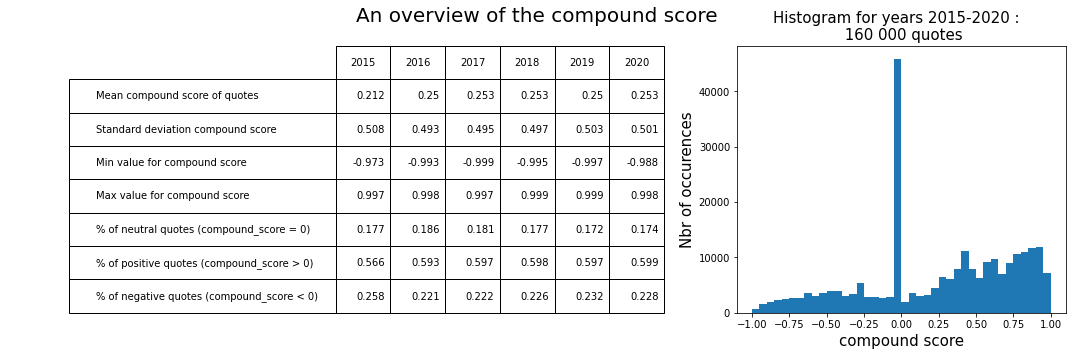

In [ ]:
# Extract information on graph_add_features 
show_compound_score = graph_add_features.copy()

# Check the proportion of neutral, positive and negative compound scores
show_compound_score["neutral"] = np.where(show_compound_score["compound_score"]==0,1,0)
show_compound_score["pos"] = np.where(show_compound_score["compound_score"]>0,1,0)
show_compound_score["neg"] = np.where(show_compound_score["compound_score"]<0,1,0)

show_compound_score = show_compound_score.groupby(["year"]).agg({'compound_score': ['mean','std','min','max'],'neutral':['mean'],'pos':['mean'],'neg':['mean']})
show_compound_score.columns = show_compound_score.columns.to_flat_index()   

# Change the columns name for better interpretation
show_compound_score = show_compound_score.rename(columns={show_compound_score.columns[0]:'Mean compound score of quotes', show_compound_score.columns[1]: "Standard deviation compound score",
                                                      show_compound_score.columns[2]:'Min value for compound score',show_compound_score.columns[3]:'Max value for compound score',
                                                      show_compound_score.columns[4]:'% of neutral quotes (compound_score = 0)',show_compound_score.columns[5]:'% of positive quotes (compound_score > 0)',
                                                      show_compound_score.columns[6]:'% of negative quotes (compound_score < 0)'})
show_compound_score = show_compound_score.T.round(3)

# Chow result : dataframe and histogram side by side 
plt.rcParams["figure.figsize"] = [15,5]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
fig.suptitle('An overview of the compound score', fontsize=20)
ax1 = fig.add_subplot(121)
font_size = 20
ax1.axis('off')
bbox = [1, 0, 1, 1]
mpl_table = ax1.table(cellText=show_compound_score.values, rowLabels=show_compound_score.index, bbox=bbox, colLabels=show_compound_score.columns, loc='center')
ax2 = fig.add_subplot(122)
ax2.hist(x= graph_add_features.compound_score, bins=40)
ax2.set_ylabel('Nbr of occurences', size=15)
ax2.set_title('Histogram for years 2015-2020 :  \n 160 000 quotes', size=15)
ax2.set_xlabel('compound score', size=15)
plt.savefig(path_to_figures + "compound_score.png")
plt.savefig(path_to_figures + "compound_score.svg")
plt.show()

The uppergraphs give us the following information :
- In average our quotes have a mean compound score of 0.24 
- The maximal and minimal value of the compound score are respectevly 1 and -1 
- 17% of our quotes are neutral (compound_score equal to 0)
- 60 % of our quotes are positive (100 000 quotes)
- 23 % of our quotes are negative (40 000 quotes)
- The histogram shows us that we do not have a gaussian distribution.

This means that we have 3 times more positive quotes than negative quotes.  

### 4.2 Fun Facts

#### 4.2.1. Old vs young

In [ ]:
graph_reduce_feature_statistics = graph_add_features.copy()

# Compound score of age
graph_reduce_feature_statistics['age_indicator'] = np.where(
    graph_reduce_feature_statistics['speaker_age'] > graph_reduce_feature_statistics['mention_age'],
    "Speaker is older than the mentionned subject:","Speaker is younger than the mentionned subject:")

graph_reduce_feature_statistics[['age_indicator','compound_score']].groupby('age_indicator').agg(['count','mean'])

compound_score          
                                                         count      mean
age_indicator                                                           
Speaker is older than the mentionned subject:           109487  0.256576
Speaker is younger than the mentionned subject:         140539  0.247569

#### 4.2.2. Women vs Men

In [ ]:
# Compound score for gender
def conditions(x,y):
    if x > y: return "Speaker is a man, mentions a woman:"
    elif x == y == 0 : return "Speaker is a woman, mentions a woman."
    elif x == y == 1 : return "Speaker is a man, mentions a man."
    else: return "Speaker is a woman, mentions a man:"

func = np.vectorize(conditions)
graph_reduce_feature_statistics['gender_indicator'] = func(
    graph_reduce_feature_statistics["speaker_gender"],graph_reduce_feature_statistics["mention_gender"])

graph_reduce_feature_statistics[['gender_indicator','compound_score']].groupby('gender_indicator').agg(['count','mean'])

compound_score          
                                               count      mean
gender_indicator                                              
Speaker is a man, mentions a man.             167079  0.254342
Speaker is a man, mentions a woman:            32051  0.249524
Speaker is a woman, mentions a man:            31519  0.222864
Speaker is a woman, mentions a woman.          19377  0.277019

We will test the hypothesis: Do people speak in a friendlier way to people of their same gender? It seems that the difference between "Speaker is a woman, mentions a man" and "Speaker is a woman, mentions a woman" is quite high. Let's check if it is statistically significant. 

In [ ]:
# Group women mentionning women, and women mentionning man 
group_women_women = graph_reduce_feature_statistics[(graph_reduce_feature_statistics['speaker_gender']==0) | (graph_reduce_feature_statistics['mention_gender']==0)]['compound_score'].values.tolist()
group_women_men = graph_reduce_feature_statistics[(graph_reduce_feature_statistics['speaker_gender']==0) | (graph_reduce_feature_statistics['mention_gender']==1)]['compound_score'].values.tolist()
group_men_men = graph_reduce_feature_statistics[(graph_reduce_feature_statistics['speaker_gender']==1) | (graph_reduce_feature_statistics['mention_gender']==1)]['compound_score'].values.tolist()
group_men_women = graph_reduce_feature_statistics[(graph_reduce_feature_statistics['speaker_gender']==1) | (graph_reduce_feature_statistics['mention_gender']==0)]['compound_score'].values.tolist()

# t-test with scipy for women -> women and women -> men)
t_check=stats.ttest_ind(group_women_women, group_women_men)
alpha=0.05 # Threshold
if(t_check[1]<alpha):
    print('The difference is statistically significant between Women -> Women and Women -> Men. p-value is', t_check[1])

# t-test with scipy for men -> men and men -> women)
t_check=stats.ttest_ind(group_men_men, group_men_women)
alpha=0.05 # Threshold
if(t_check[1]<alpha):
    print('The difference is statistically significant between Men -> Men and Men -> Women. p-value is', t_check[1])

The difference is statistically significant between Women -> Women and Women -> Men. p-value is 0.0033145465050914914
The difference is statistically significant between Men -> Men and Men -> Women. p-value is 2.3404184286917742e-05


#### 4.2.3. Trump and Biden vs the world/gender/religion/politics and themselves

In [ ]:
# Trump and Biden vs the world
Trump_id = "Q22686"
Biden_id = "Q6279"

def conditions(id_speaker, id_mention):
    if id_speaker == Trump_id : return "Trump is speaking by mentioning someone"
    if id_speaker == Biden_id : return "Biden is speaking by mentioning someone"
    if id_mention == Trump_id : return "People are speaking to Trump"
    if id_mention == Biden_id : return "People are speaking to Biden"

# Select only the rows where Biden and Trump are involved 
df_general_biden_trump = graph_reduce_feature_statistics.loc[(graph_reduce_feature_statistics['mention_id'] == Biden_id) | 
                                                     (graph_reduce_feature_statistics['mention_id'] == Trump_id) | 
                                                     (graph_reduce_feature_statistics['speaker_id'] == Biden_id) | 
                                                     (graph_reduce_feature_statistics['speaker_id'] == Trump_id)]
# Apply function conditions
func = np.vectorize(conditions)
df_general_biden_trump['Trump_biden_vs_the_world'] = func(df_general_biden_trump["speaker_id"],df_general_biden_trump["mention_id"])

# Group by the category previously created by function "conditions", compute the mean per group and count the number of quotes 
df_general_biden_trump[['Trump_biden_vs_the_world','compound_score']].groupby('Trump_biden_vs_the_world').agg(['count','mean'])

compound_score          
                                                 count      mean
Trump_biden_vs_the_world                                        
Biden is speaking by mentioning someone            947  0.093236
People are speaking to Biden                      2785  0.235131
People are speaking to Trump                     13178  0.086977
Trump is speaking by mentioning someone           5544  0.106222

In [ ]:
# Trump and Biden vs gender
Trump_id = "Q22686"
Biden_id = "Q6279"

def conditions(id_speaker, id_mention, gender_speaker, gender_mention):
    if id_speaker == Trump_id :
      if id_mention == Trump_id : return "Trump is speaking about him"
      if id_mention == Biden_id : return "Trump is mentioning Biden"
      if gender_mention == 1 : return "Trump is mentioning a man"
      if gender_mention == 0 : return "Trump is mentioning a woman"  
    if id_speaker == Biden_id :
      if id_mention == Biden_id : return "Biden is speaking about him"
      if id_mention == Trump_id : return "Biden is mentioning Trump"
      if gender_mention == 1 : return "Biden is mentioning a man"
      if gender_mention == 0 : return "Biden is mentioning a woman"  
    if gender_speaker == 0 :
      if id_mention == Biden_id : return "Woman when speaking about Biden"
      if id_mention == Trump_id : return "Woman when speaking about Trump"
    if gender_speaker == 1 :
      if id_mention == Biden_id : return "Man when speaking about Biden"
      if id_mention == Trump_id : return "Man when speaking about Trump"

# Select only the rows where Biden and Trump are involved 
df_trump_biden = graph_reduce_feature_statistics.loc[(graph_reduce_feature_statistics['mention_id'] == Biden_id) | 
                                                     (graph_reduce_feature_statistics['mention_id'] == Trump_id) | 
                                                     (graph_reduce_feature_statistics['speaker_id'] == Biden_id) | 
                                                   (graph_reduce_feature_statistics['speaker_id'] == Trump_id)]
# Apply function conditions
func = np.vectorize(conditions)
df_trump_biden['Trump_biden_vs_gender'] = func(
    df_trump_biden["speaker_id"],df_trump_biden["mention_id"],df_trump_biden["speaker_gender"],df_trump_biden["mention_gender"])

# Group by the category previously created by function "conditions", compute the mean per group and count the number of quotes 
df_trump_biden[['Trump_biden_vs_gender','compound_score']].groupby('Trump_biden_vs_gender').agg(['count','mean'])

compound_score          
                                         count      mean
Trump_biden_vs_gender                                   
Biden is mentioning Trump                  222 -0.029555
Biden is mentioning a man                  432  0.171697
Biden is mentioning a woman                109  0.088831
Biden is speaking about him                184  0.059782
Man when speaking about Biden             2228  0.244143
Man when speaking about Trump            10197  0.092382
Trump is mentioning Biden                  129  0.035240
Trump is mentioning a man                 3282  0.127439
Trump is mentioning a woman               1221  0.045328
Trump is speaking about him                912  0.121434
Woman when speaking about Biden            557  0.199085
Woman when speaking about Trump           2981  0.068490

In [ ]:
# Trump and Biden vs politics
Trump_id = "Q22686"
Biden_id = "Q6279"

def conditions(id_speaker, id_mention, speaker_party, mention_party):
    if id_speaker == Trump_id :
      if mention_party == "Republican Party" : return "Trump is mentioning Republicans"
      if mention_party == "Democratic Party" : return "Trump is mentioning Democrats"
    if id_speaker == Biden_id : 
      if mention_party == "Republican Party" : return "Biden is mentioning Republicans"
      if mention_party == "Democratic Party" : return "Biden is mentioning Democrats"
    if speaker_party == "Democratic Party" : 
      if id_mention == Trump_id : return "Democrats are speaking about Trump"
      if id_mention == Biden_id : return "Democrats are speaking about Biden"
    if speaker_party == "Republican Party" : 
      if id_mention == Trump_id : return "Republicans are speaking about Trump"
      if id_mention == Biden_id : return "Republicans are speaking about Biden"

df_politics = graph_reduce_feature_statistics.loc[(graph_reduce_feature_statistics['mention_party'] == "Democratic Party")|
                                                  (graph_reduce_feature_statistics['mention_party'] == "Republican Party")|
                                                  (graph_reduce_feature_statistics['speaker_party'] == "Democratic Party")| 
                                                     (graph_reduce_feature_statistics['speaker_party'] == "Republican Party")]

# Select only the rows where Biden and Trump are involved 
df_trump_biden = df_politics.loc[(df_politics['mention_id'] == Biden_id) | 
                                                     (df_politics['mention_id'] == Trump_id) | 
                                                     (df_politics['speaker_id'] == Biden_id) | 
                                                     (df_politics['speaker_id'] == Trump_id)]
# Apply function conditions
func = np.vectorize(conditions)
df_trump_biden['Trump_biden_vs_politics'] = func(
    df_trump_biden["speaker_id"],df_trump_biden["mention_id"],df_trump_biden["speaker_party"],df_trump_biden["mention_party"])

# Group by the category previously created by function "conditions", compute the mean per group and count the number of quotes 
df_trump_biden[['Trump_biden_vs_politics','compound_score']].groupby('Trump_biden_vs_politics').agg(['count','mean'])

compound_score          
                                              count      mean
Trump_biden_vs_politics                                      
Biden is mentioning Democrats                   383  0.096981
Biden is mentioning Republicans                 285  0.011048
Democrats are speaking about Biden              564  0.234161
Democrats are speaking about Trump             3586  0.005030
Republicans are speaking about Biden            272  0.142860
Republicans are speaking about Trump           4004  0.189514
Trump is mentioning Democrats                  1649  0.007755
Trump is mentioning Republicans                1959  0.130534

In [ ]:
# Trump and Biden vs muslims

def conditions(id_speaker, id_mention):
    if id_speaker == Trump_id : return "Trump is mentioning a muslim"
    if id_speaker == Biden_id : return "Biden is mentioning a muslim"
    if id_mention == Trump_id : return "When muslims are speaking about Trump"
    if id_mention == Biden_id : return "When muslims are speaking about Biden"

# Different religions associated with muslims 
religions = ['Islam', 'Sunni Islam', 'Shia Islam', 'Quranism']

# Select only the rows where Biden and Trump are involved 
df_religion = graph_reduce_feature_statistics.loc[(graph_reduce_feature_statistics['mention_id'] == Biden_id) | 
                                                     (graph_reduce_feature_statistics['mention_id'] == Trump_id) | 
                                                     (graph_reduce_feature_statistics['speaker_id'] == Biden_id) | 
                                                     (graph_reduce_feature_statistics['speaker_id'] == Trump_id)]

# Select only the rows with religion that is in the list of religions 
df_religion = df_religion[(df_religion['speaker_religion'].isin(religions)) | (df_religion['mention_religion'].isin(religions))]

# Apply function conditions
func = np.vectorize(conditions)
df_religion['Trump_biden_vs_religion'] = func(df_religion["speaker_id"],df_religion["mention_id"])

# Group by the category previously created by function "conditions", compute the mean per group and count the number of quotes 
df_religion[['Trump_biden_vs_religion','compound_score']].groupby('Trump_biden_vs_religion').agg(['count','mean'])

compound_score          
                                               count      mean
Trump_biden_vs_religion                                       
Biden is mentioning a muslim                       8  0.082662
Trump is mentioning a muslim                     161 -0.185207
When muslims are speaking about Biden             13 -0.029915
When muslims are speaking about Trump            197 -0.034782

In [ ]:
# Trump and Biden vs Mexico
def conditions(id_speaker, id_mention):
    if id_speaker == Trump_id : return "Trump is speaking to mexicans"
    if id_speaker == Biden_id : return "Biden is speaking to mexicans"
    if id_mention == Trump_id : return "When mexicans are speaking to Trump"
    if id_mention == Biden_id : return "When mexicans are speaking to Biden"

# Select only the rows where Biden and Trump are involved 
df_country = graph_reduce_feature_statistics.loc[(graph_reduce_feature_statistics['mention_id'] == Biden_id) | 
                                                     (graph_reduce_feature_statistics['mention_id'] == Trump_id) | 
                                                     (graph_reduce_feature_statistics['speaker_id'] == Biden_id) | 
                                                     (graph_reduce_feature_statistics['speaker_id'] == Trump_id)]

# Select ony the rows where nationality contains 'Mexi' to detect the names -> 'Mexico', 'Mexico–United States border', 'State of Mexico','Mexico City'
df_country['mention_nationality'] = df_country['mention_nationality'].astype(str)
df_country['speaker_nationality'] = df_country['speaker_nationality'].astype(str)
df_country = df_country[(df_country['mention_nationality'].str.contains("Mexi"))| (df_country['speaker_nationality'].str.contains("Mexi"))]

# Apply function conditions
func = np.vectorize(conditions)
df_country['Trump_biden_vs_country'] = func(df_country["speaker_id"],df_country["mention_id"])

# Group by the category previously created by function "conditions", compute the mean per group and count the number of quotes 
df_country[['Trump_biden_vs_country','compound_score']].groupby('Trump_biden_vs_country').agg(['count','mean'])

compound_score          
                                             count      mean
Trump_biden_vs_country                                      
Trump is speaking to mexicans                    1  0.577700
When mexicans are speaking to Biden              3  0.337433
When mexicans are speaking to Trump             14 -0.075429

It seems that we do not have enough quotes that respect these conditions. 

### 4.3. Missing values in our features from Wikidata

Wikidata allowed us to attribute features to each of our subjects. However there are a lot of missing values. Only 1% of our rows have an academic degree value, 6% for the religion, 14% for the party, 5% for the ethnic group and 76% for the nationality. These numbers increase if we take the 500 most popular subjects, but we are still under 50%.

In [ ]:
# Calculate the % of missing values per colum
missing_full = popularity_add_features[['academic_degree','religion','party','ethnic_group','nationality']].isna().sum()/popularity_add_features.shape[0]

# Calculate the % of real values per column
show = 100* (1 - round(missing_full,2)).to_frame().T
show.insert(loc=0, column='dataset', value=["% of values per category"])
show.style.set_caption("For the entire list of unique speakers and unique person mentioned : 2015-2020")

,dataset,academic_degree,religion,party,ethnic_group,nationality
0,% of values per category,1.000000,6.000000,15.000000,5.000000,77.000000


## 5. Labeling by hand the features of the 500 most popular subjects  

### 5.1 popularity_add_features_top_500

**Selecting the top 500**

Advancing further we will only use the top 500, this is mainly for two reasons:
- As seen previously, we have a lot of missing values. If we want to see the correlation between some features and the communities, we will need more complete data. By selecting only the 500 most popular persons, we will be able to label data by hand. 
- Our concept does not need more than 500 persons to work. Because of natural graphs being very mixed, visualizing a graph of much more than 500 persons would also become messy and hard to grasp visually.

We still have a lot of connections if we look at only the quotes that have a speaker and mentioned person in the top 500. 



In [ ]:
# Select the first 500 subjects (popularity_add_features is sorted on the popularity score in descending order)
popularity_add_features_top_500 = popularity_add_features.head(500)
popularity_add_features_top_500.head(7)

,id,mean_speaker,count_speaker,mean_mentioned,count_mentioned,popularity_score,label,gender,party,academic_degree,religion,nationality,ethnic_group,age
0,Q22686,0.106222,5544.0,0.087365,14312.0,19856.0,Donald Trump,1,Republican Party,Bachelor of Science,Presbyterianism,[United States of America],None,74.0
1,Q6294,0.114065,832.0,0.084523,4302.0,5134.0,Hillary Clinton,0,Democratic Party,bachelor's degree,Methodism,[United States of America],None,73.0
2,Q6279,0.093236,947.0,0.216393,3098.0,4045.0,Joe Biden,1,Democratic Party,Juris Doctor,Catholicism,[United States of America],None,78.0
3,Q76,0.233879,671.0,0.098316,2052.0,2723.0,Barack Obama,1,Democratic Party,Bachelor of Arts,Protestantism,[United States of America],"[African Americans, Multiracial American, Luo ...",59.0
4,Q359442,0.124266,1182.0,0.165219,1308.0,2490.0,Bernie Sanders,1,Liberty Union Party,Bachelor of Arts,Judaism,[United States of America],[Jewish people],79.0
5,Q1058,0.260138,716.0,0.154440,1473.0,2189.0,Narendra Modi,1,Bharatiya Janata Party,None,Hinduism,[India],"[Gujarati people, Modh]",70.0
6,Q607,0.148310,345.0,0.230745,1527.0,1872.0,Michael Bloomberg,1,Democratic Party,None,Judaism,[United States of America],[Jewish people],78.0


**Adding some extra features labeled by hand**

As you can see Narendra Modi and Michael Bloomberg appears to have no degrees but they very well do! The top 500 persons have been labeled by hand. This has meant standardizing degrees that are equivalent to a bachelors to be called "Bachelors", degrees equivalent to a masters to be called "Masters" as well as doctorate to "Phd". Furthermore the religions have been composed into 7 groups: Islam, Christianity, Indian, Judaism, Buddhism, Atheism, Other or none where "Indian" represents the indian religions such as Hinduism and Sikhism.

We also added a feature named "career": ('Politics', 'Culture', 'Sports', 'Industry', 'Academic', 'Military', 'sports', 'Other', 'politics') for each person. 

In [ ]:
# Merging popularity_add_features with the labeled features
top_500_labeled = pd.read_csv(path_to_labeled_features)

popularity_add_features_top_500 = popularity_add_features_top_500.drop(columns=["label","gender","party","academic_degree","religion","nationality","ethnic_group"],axis=1)
popularity_add_features_top_500 = popularity_add_features_top_500.merge(top_500_labeled, on="id", how="inner")
popularity_add_features_top_500.head(7)

,id,mean_speaker,count_speaker,mean_mentioned,count_mentioned,popularity_score,age,label,gender,party,academic_degree,religion,nationality,ethnic_group,career
0,Q22686,0.106222,5544.0,0.087365,14312.0,19856.0,74.0,Donald Trump,1,Republican Party,Bachelors,Christianity,['United States of America'],White,Politics
1,Q6294,0.114065,832.0,0.084523,4302.0,5134.0,73.0,Hillary Clinton,0,Democratic Party,Bachelors,Christianity,['United States of America'],White,Politics
2,Q6279,0.093236,947.0,0.216393,3098.0,4045.0,78.0,Joe Biden,1,Democratic Party,Masters,Christianity,['United States of America'],White,Politics
3,Q76,0.233879,671.0,0.098316,2052.0,2723.0,59.0,Barack Obama,1,Democratic Party,Bachelors,Christianity,['United States of America'],Black,Politics
4,Q359442,0.124266,1182.0,0.165219,1308.0,2490.0,79.0,Bernie Sanders,1,Liberty Union Party,Bachelors,Judaism,['United States of America'],White,Politics
5,Q1058,0.260138,716.0,0.154440,1473.0,2189.0,70.0,Narendra Modi,1,Bharatiya Janata Party,Masters,Indian,['India'],Asian,Politics
6,Q607,0.148310,345.0,0.230745,1527.0,1872.0,78.0,Michael Bloomberg,1,Democratic Party,Masters,Judaism,['United States of America'],White,Politics


**Voila!**

Now Modi and Bloomberg have their degrees, Masters for both, nice work guys!

### 5.2 Sanity check for popularity_add_features_top_500 

In [ ]:
# Calculate the % of missing values per colum
missing_top_500 = popularity_add_features_top_500[['academic_degree','religion','party','ethnic_group','nationality','career']].isna().sum()/popularity_add_features.shape[0]

# Calculate the % of real values per column
show = 100* (1 - round(missing_top_500, 2)).to_frame().T
show.insert(loc=0, column='dataset', value=["% of values per category"])
show.style.set_caption("For the top 500 subjects")

,dataset,academic_degree,religion,party,ethnic_group,nationality,career
0,% of values per category,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


### 5.3 graph_top_500

We create graph_top_500 which is the graph with speaker and mention person that are in the top 500 person. graph_top_500 will be used to create our final graph. 



In [ ]:
# Create graph_top_500 dataframe 
graph_top_500 = graph.copy()

# We select in the sorted popularity dataframe the 500 first rows 
top_500_id = popularity['id'].head(500).tolist()

# Drop all rows with a mentioned id or speaker id not in the top 500
graph_top_500 = graph_top_500[graph_top_500["mention_id"].isin(top_500_id)]
graph_top_500 = graph_top_500[graph_top_500["speaker_id"].isin(top_500_id)]

# Save for later
graph_top_500.to_csv(path_to_graph_top_500,index=False)

## 6. Analysis of the top 500 most popular subjects 

### 6.1 General statistics 

In [ ]:
print("As expected, we have {} of unique subjects in our graph_top_500.".format(popularity_add_features_top_500.id.nunique()))
print("{} of them speaks about a person that are in the top 500 subjects.".format(graph_top_500.mention_id.nunique()))
print("{} of them were mentioned by a person that is in the top 500 subjects.\n".format(graph_top_500.speaker_id.nunique()))

print("For years 2015 - 2020 :")
print("We have {} of connections between the top 500 subjects.\nWhich represents {}% of the total connections of the graph containing every subject (2015-2020).\n".format(graph_top_500.shape[0],100*graph_top_500.shape[0]/graph.shape[0]))

print("For the year 2020 :")
nbr_connections_2020 = graph[graph["year"]=="2020"].shape[0]
nbr_connections_top_500_2020 = graph_top_500[graph_top_500["year"]=="2020"].shape[0]
print("We have {} of connections between the top 500 subjects.\nWhich represents {}% of the total connections of the graph containing every subject in 2020.".format(nbr_connections_top_500_2020,100*nbr_connections_top_500_2020/nbr_connections_2020))

As expected, we have 471 of unique subjects in our graph_top_500.
497 of them speaks about a person that are in the top 500 subjects.
478 of them were mentioned by a person that is in the top 500 subjects.

For years 2015 - 2020 :
We have 36008 of connections between the top 500 subjects.
Which represents 14.401702222968812% of the total connections of the graph containing every subject (2015-2020).

For the year 2020 :
We have 9107 of connections between the top 500 subjects.
Which represents 16.466567822659385% of the total connections of the graph containing every subject in 2020.


### 6.2 List of the top 10 most popular people per year  

In [ ]:
# Show the 10 most popular people for all years

# 10 most popular considering the 6 years
most_popular_people_6_years = popularity_add_features_top_500[['label','popularity_score']].iloc[:10]

# 10 most popular for every year 2015-2020 
popularity_by_year_with_names = popularity_by_year.merge(popularity_add_features_top_500[['label','id']],on="id",how="inner" )
most_popular_people = popularity_by_year_with_names.sort_values(['popularity_score'],ascending=False).groupby('year').head(10)

# Create dataframe 
data_2015 = zip(list(most_popular_people.loc[most_popular_people['year'] == "2015", 'label']), list(most_popular_people.loc[most_popular_people['year'] == "2015", 'popularity_score']))
data_2016 = zip(list(most_popular_people.loc[most_popular_people['year'] == "2016", 'label']), list(most_popular_people.loc[most_popular_people['year'] == "2016", 'popularity_score']))
data_2017 = zip(list(most_popular_people.loc[most_popular_people['year'] == "2017", 'label']), list(most_popular_people.loc[most_popular_people['year'] == "2017", 'popularity_score']))
data_2018 = zip(list(most_popular_people.loc[most_popular_people['year'] == "2018", 'label']), list(most_popular_people.loc[most_popular_people['year'] == "2018", 'popularity_score']))
data_2019 = zip(list(most_popular_people.loc[most_popular_people['year'] == "2019", 'label']), list(most_popular_people.loc[most_popular_people['year'] == "2019", 'popularity_score']))
data_2020 = zip(list(most_popular_people.loc[most_popular_people['year'] == "2020", 'label']), list(most_popular_people.loc[most_popular_people['year'] == "2020", 'popularity_score']))
data_6_years = zip(list(most_popular_people_6_years['label']),list(most_popular_people_6_years['popularity_score']))

# Create data frame with a column per year + last column is for all the years combined
data = {'Year 2015': list(data_2015),'Year 2016': list(data_2016),
        'Year 2017': list(data_2017),'Year 2018': list(data_2018),
        'Year 2019': list(data_2019),'Year 2020': list(data_2020),
        'All years combined': list(data_6_years)}

show_10_most_popular = pd.DataFrame(data)
  
# Make a better layout for each cell
def visualization(x):
    return x[0] + " ("+str(int(x[1]))+")"

show_10_most_popular = show_10_most_popular.applymap(visualization)

# Change cell color for specific names 
def color_for_names(cell_value):
    if "Donald Trump" in cell_value : return 'background-color: indianred;'
    if "Barack Obama" in cell_value : return 'background-color: magenta;'
    if "Joe Biden" in cell_value : return 'background-color: gold;'
    if "Vladimir Putin" in cell_value : return 'background-color: yellow;'
    if "Narendra Modi" in cell_value : return 'background-color: orange;'
    if "Hillary Clinton" in cell_value : return 'background-color: pink;'
    if "Bernie Sanders" in cell_value : return 'background-color: cyan;'
    return 'background-color: light grey;'

# Show result 
show_10_most_popular.style.applymap(color_for_names).set_caption("Top 10 most popular subjects per year. The popularity score is shown in ().")

,Year 2015,Year 2016,Year 2017,Year 2018,Year 2019,Year 2020,All years combined
0,Donald Trump (209),Donald Trump (4405),Donald Trump (3548),Donald Trump (3555),Donald Trump (3806),Donald Trump (4333),Donald Trump (19856)
1,Bernie Sanders (62),Hillary Clinton (3595),Hillary Clinton (530),Vladimir Putin (516),Joe Biden (958),Joe Biden (2057),Hillary Clinton (5134)
2,Joe Biden (52),Barack Obama (1260),Barack Obama (429),Rahul Gandhi (424),Narendra Modi (736),Bernie Sanders (1335),Joe Biden (4045)
3,Narendra Modi (31),Bernie Sanders (592),Vladimir Putin (351),Narendra Modi (416),Boris Johnson (620),Michael Bloomberg (869),Barack Obama (2723)
4,Michael Bloomberg (29),Ted Cruz (534),Narendra Modi (331),Hillary Clinton (375),Rahul Gandhi (566),Mike Pompeo (535),Bernie Sanders (2490)
5,Kobe Bryant (26),Vladimir Putin (384),Joe Biden (298),Mike Pompeo (366),Benjamin Netanyahu (455),Pete Buttigieg (500),Narendra Modi (2189)
6,Pete Buttigieg (24),Joe Biden (367),James Comey (281),Brett Kavanaugh (357),Mike Pompeo (388),Narendra Modi (444),Michael Bloomberg (1872)
7,Benjamin Netanyahu (23),Mike Pence (320),Chris Harrison (278),Barack Obama (342),Barack Obama (312),Benjamin Netanyahu (429),Mike Pompeo (1786)
8,Kerry Washington (21),Chris Harrison (317),Mike Pompeo (249),John Cornyn (317),Robert Mueller (311),Mitch McConnell (404),Vladimir Putin (1715)
9,Boris Johnson (20),Taylor Swift (258),John Cornyn (247),Joe Biden (313),Michael Bloomberg (296),Boris Johnson (390),Rahul Gandhi (1573)


We can see that the most popular subjects are mainly american/men politicians. Donald Trump is leading the group almost every year, with a popularity score that can be 6 times bigger than the second most popular subjects in the same year. We can see the impact of the 2020 United States presidential election on the score of Biden. 

### 6.3 Distribution of the popularity score 

Text(0.5, 1.0, 'Distribution of popularity score for top 500 persons in year 2020')

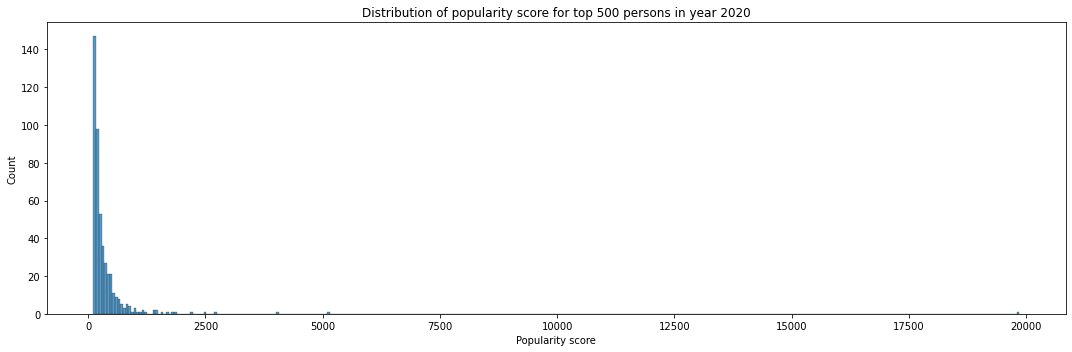

In [ ]:
sns.histplot(data=popularity_add_features_top_500["popularity_score"])
plt.xlabel("Popularity score")
plt.ylabel("Count")
plt.title("Distribution of popularity score for top 500 persons in year 2020")


In [ ]:
# Describtion of the popularity score 2015-2020
print("  For years 2015-2020:   ")
popularity_add_features_top_500.popularity_score.describe()

  For years 2015-2020:   


count      471.000000
mean       386.808917
std        991.837086
min        114.000000
25%        157.500000
50%        222.000000
75%        380.500000
max      19856.000000
Name: popularity_score, dtype: float64

In [ ]:
# Describtion of the popularity score 2020
print("  For year 2020:  ")
popularity_by_year[popularity_by_year["year"]=="2020"].sort_values(by="popularity_score", ascending=False).head(500).popularity_score.describe()

  For year 2020:  


count     500.000000
mean       90.136000
std       231.674469
min        26.000000
25%        33.000000
50%        46.000000
75%        84.000000
max      4333.000000
Name: popularity_score, dtype: float64

### 6.4 Analysis top 500 persons labeled

We load the labeled top 500 persons:

In [ ]:
top_500 = pd.read_csv(path_to_labeled_features)

We extract statistics on these 500 persons:

In [ ]:
# Gender
num_women = top_500[top_500["gender"] == 0].shape[0]

# Party
num_republicans = top_500[top_500["party"] == "Republican Party"].shape[0]
num_democrats = top_500[top_500["party"] == "Democratic Party"].shape[0]
num_other_parties = 500 - num_republicans - num_democrats - 262 # 262 is hardcoded the number of "None" which are not valid

# Ethnicity
num_black =  top_500[top_500["ethnic_group"] == "Black"].shape[0]
num_white =  top_500[top_500["ethnic_group"] == "White"].shape[0]
num_hispanic = top_500[top_500["ethnic_group"] == "Hispanic"].shape[0]
num_asian = top_500[top_500["ethnic_group"] == "Asian"].shape[0]

# Nationality
def get_top_5_nationalities(top_500):
  countries = pd.DataFrame(columns=["country","count"])
  for index, row in top_500.iterrows():
    countries_row = row["nationality"]
    countries_row_list = countries_row[1:-1].replace("'","").split(",")
    for country in countries_row_list:
        countries = countries.append({'country': country, "count":1}, ignore_index=True)
  countries = countries.groupby("country").count()
  return countries.sort_values("count",ascending=False).head(5).reset_index()
top_5_nationalities = get_top_5_nationalities(top_500)

# Religion
religions_aggregated = top_500["religion"].value_counts().head(6).to_frame()

# Career
careers_aggregated = top_500["career"].value_counts().reset_index()

Now we plot!

**Plotting gender**

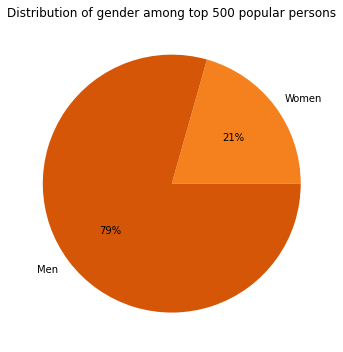

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define data
data = [num_women, 500-num_women]
labels = ['Women', 'Men']

# Define Seaborn color palette to use
colors = sns.color_palette("YlOrBr")[3:5]

# Create pie chart
plt.title("Distribution of gender among top 500 popular persons")
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.savefig(path_to_figures + "gender.svg",bbox_inches='tight')
plt.show()

**Plotting political parties**

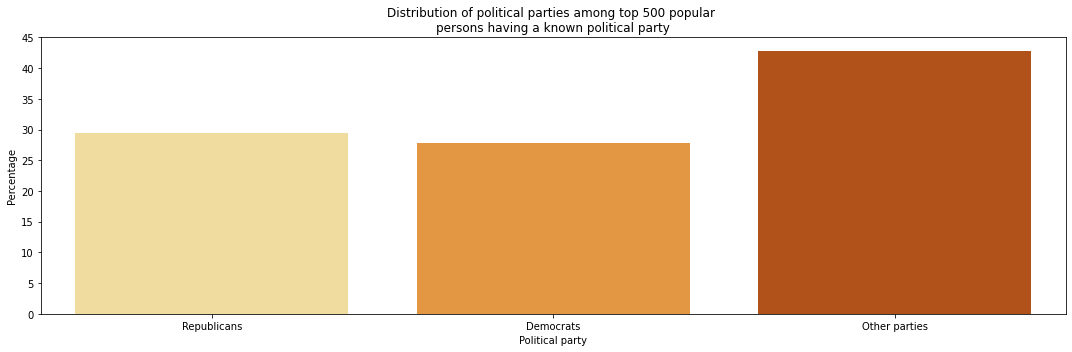

In [ ]:
total = num_republicans + num_democrats + num_other_parties
d = {'Political party': ["Republicans", "Democrats", "Other parties"], 'Percentage': [100*num_republicans/total, 100*num_democrats/total,100*num_other_parties/total]}
df = pd.DataFrame(data=d)
plt.title("Distribution of political parties among top 500 popular \npersons having a known political party")
ax = sns.barplot(x="Political party", y="Percentage", data=df, palette="YlOrBr")
plt.savefig(path_to_figures + "political_party.svg",bbox_inches='tight')

**Plotting ethnicity**

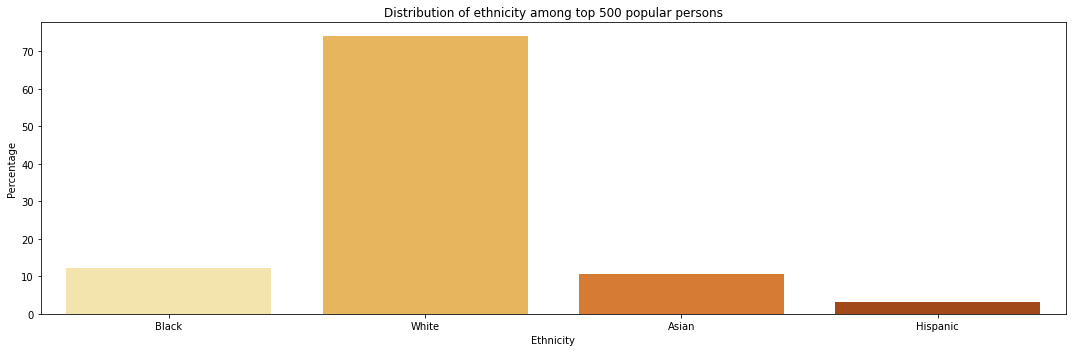

In [ ]:
d = {'Ethnicity': ["Black", "White", "Asian","Hispanic"], 'Percentage': [num_black/5, num_white/5,num_asian/5, num_hispanic/5]}
df = pd.DataFrame(data=d)
plt.title("Distribution of ethnicity among top 500 popular persons")
ax = sns.barplot(x="Ethnicity", y="Percentage", data=df, palette="YlOrBr")
plt.savefig(path_to_figures + "ethnicity.svg",bbox_inches='tight')

**Plotting nationality**

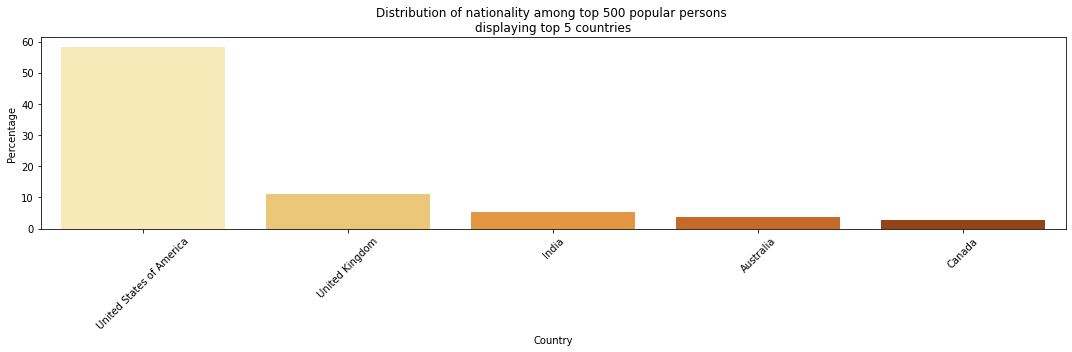

In [ ]:
top_5_nationalities["count"] = top_5_nationalities["count"]/5
plt.title("Distribution of nationality among top 500 popular persons \ndisplaying top 5 countries")
ax = sns.barplot(x="country", y="count", data=top_5_nationalities, palette="YlOrBr")
plt.ylabel("Percentage")
plt.xlabel("Country")
plt.xticks(rotation=45)
plt.savefig(path_to_figures + "nationality.svg",bbox_inches='tight')

**Plotting religion**

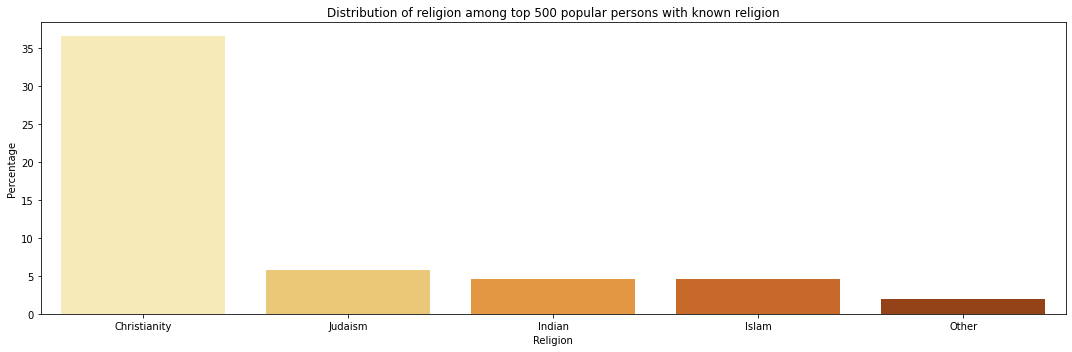

In [ ]:
percentage_values = [religions_aggregated["religion"][1]/5, religions_aggregated["religion"][2]/5, 
                     religions_aggregated["religion"][3]/5, religions_aggregated["religion"][4]/5,
                     religions_aggregated["religion"][5]/5]
d = {'Religion': ["Christianity", "Judaism", "Indian","Islam","Other"], 'Percentage':percentage_values}
df = pd.DataFrame(data=d)
plt.title("Distribution of religion among top 500 popular persons with known religion")
ax = sns.barplot(x="Religion", y="Percentage", data=df, palette="YlOrBr")
plt.savefig(path_to_figures + "religion.svg",bbox_inches='tight')

**Plotting career**

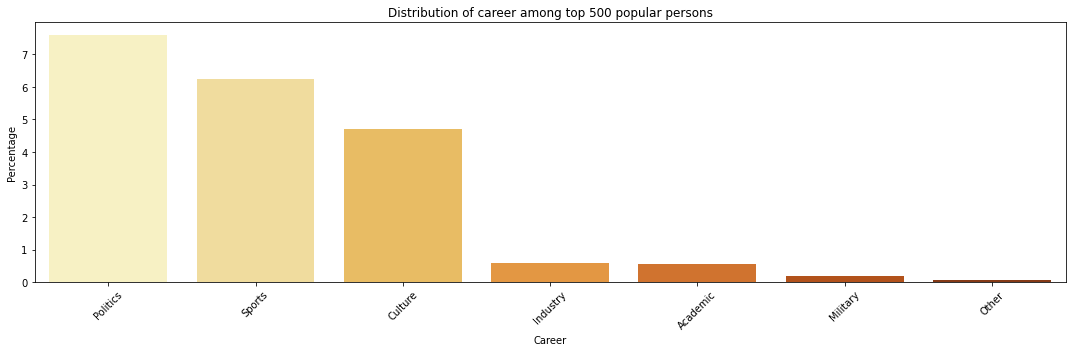

In [ ]:
careers_aggregated["career"] = careers_aggregated["career"]/5
plt.title("Distribution of career among top 500 popular persons")
ax = sns.barplot(x="index", y="career", data=careers_aggregated, palette="YlOrBr")
plt.ylabel("Percentage")
plt.xlabel("Career")
plt.xticks(rotation=45)
plt.savefig(path_to_figures + "career.svg",bbox_inches='tight')

## 7. Community detection for 2020

### 7.0. Load the data : year 2020

In [ ]:
# Load graph_top_500
graph_top_500 = pd.read_csv(path_to_graph_top_500)

# Select only year 2020
graph_top_500 = graph_top_500[graph_top_500["year"]==2020]
graph_top_500 = graph_top_500.drop("year",axis=1)

### 7.1. Parallel edges removal 

Parallel edges: Edges that are connected to the same two nodes. 

In order to create our graph, we require only one edge between two nodes. We need to get rid of our parallel edges by aggregating them into one connetion. 

For each two nodes, we will do the mean of the compound score of all their parallel edges. Then we recompute the compound score to take into account the number of connections between the two nodes. The idea is that if the aggregated mean is negative/positive between two nodes, the more there were connections having a negative/positive sentiment score.  

Finally we apply a distance function to the recomputed compound score. We fine tune its parameters in order to improve the quality of our results. 

In [ ]:
# Show number of parallel edges (i.e edges that link the same 2 node multiple times in the same direction)
graph_parallel_edges=graph_top_500.groupby(['mention_id','speaker_id'],as_index=False).size()
graph_parallel_edges=graph_parallel_edges.rename(columns={"size":"nbr_parallel_edges"})
num_nodes_parallel_edges=graph_parallel_edges[graph_parallel_edges["nbr_parallel_edges"]>1].shape[0]
print(f'The graph has currently {num_nodes_parallel_edges} nodes having parallel edges.')
graph_parallel_edges.sort_values(by=['nbr_parallel_edges'], ascending=False).head(10)

The graph has currently 1173 nodes having parallel edges.


,mention_id,speaker_id,nbr_parallel_edges
693,Q22686,Q22686,160
2299,Q6279,Q359442,153
785,Q22686,Q6279,144
724,Q22686,Q359442,143
783,Q22686,Q607,123
2325,Q6279,Q6279,103
1384,Q359442,Q6279,93
1289,Q355522,Q380900,78
1369,Q359442,Q359442,75
793,Q22686,Q7173106,73


Text(0.5, 1.0, 'Distribution of person node in and out degree')

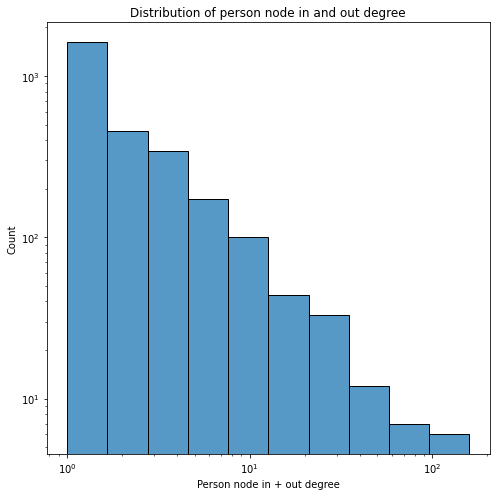

In [ ]:
f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log", yscale="log")
sns.histplot(data=graph_parallel_edges["nbr_parallel_edges"],bins=10,ax=ax)
plt.xlabel("Person node in + out degree")
plt.title("Distribution of person node in and out degree")


In [ ]:
# Recompute the compound score by taking into account the number of parallel edges
def recompute_compound(c, n):
  # it keep the property of the compound (i.e negative or positive) but it is intensified based on the number of mentions
  # n number of parallel edges, i.e number of mention times
  return c*np.log(np.e*n)

# Calculates the distance with input compound score 
def distance_parallel(x):
  # x compound value
  return np.exp(5*x)

In [ ]:
# Aggregate parallel edges and average their compound score
graph_top_500=graph_top_500.groupby(['mention_id','speaker_id'])['compound_score'].mean().reset_index()

# Add number of parallel edges to graph_top_500
graph_top_500=graph_top_500.join(graph_parallel_edges.set_index(['mention_id', 'speaker_id']), on=['mention_id', 'speaker_id'], how='inner')

# Recompute compound
graph_top_500['compound_score']=graph_top_500.apply(lambda x: recompute_compound(x['compound_score'], x['nbr_parallel_edges']), axis=1)

# Compute distance
graph_top_500['distance']=graph_top_500.apply(lambda x: distance_parallel(x['compound_score']), axis=1)

In [ ]:
# Check if there are still parallel edges
graph_parallel_edges=graph_top_500.groupby(['mention_id','speaker_id'],as_index=False).size()
graph_parallel_edges=graph_parallel_edges.rename(columns={"size":"num_edges"})
num_nodes_parallel_edges=graph_parallel_edges[graph_parallel_edges["num_edges"]>1].shape[0]
print(f'The graph has currently {num_nodes_parallel_edges} nodes having parallel edges.')
print(f'Current number of total edges {graph_top_500.shape[0]}')

The graph has currently 0 nodes having parallel edges.
Current number of total edges 2797


In [ ]:
# Show results 
graph_top_500.head(10)

,mention_id,speaker_id,compound_score,nbr_parallel_edges,distance
0,Q1000592,Q1000592,-0.680466,24,0.033296
1,Q1000592,Q16728747,-1.013280,3,0.006305
2,Q1000592,Q5162259,-0.149143,4,0.474394
3,Q1000592,Q5490233,0.635517,7,23.988749
4,Q1000592,Q573463,-0.099898,6,0.606839
5,Q1000592,Q6446228,0.607417,2,20.844346
6,Q1000592,Q887766,-0.305782,2,0.216771
7,Q1000592,Q933423,-0.425022,21,0.119420
8,Q100951071,Q100951071,-1.193620,10,0.002559
9,Q100951071,Q16189358,-1.169203,2,0.002891


### 7.2. Create .csv for gephi

We will use gephi to create our graph and find our communities. Gephi expects a csv file with the columns : "Source", "Target" and "Weight". We need to adapt our graph_top_500. 

In [ ]:
# Adapt graph_top_500 in order to be processable by gephi
graph_gephi=graph_top_500.drop(columns=['compound_score'])
graph_gephi=graph_gephi.rename(columns={"speaker_id": "Source", "mention_id": "Target", "distance":"Weight"})
graph_gephi=graph_gephi[['Source','Target','Weight']]

# Save graph_gephi and process it on gephi
graph_gephi.to_csv(path_to_graph_gephi, index=False)

### Gephi instructions :

After writing the graph in a specific form in order to be processable by the program gephi we procede in this way:
1. We import the graph_gephi.csv in Gephi by using the option "import spreadsheet"
2. For running the Louvain Algorithm:

  *   We go in the section Statistics > Network overview and run the function "Modularity"
  *   We have chosen the resolution parameter equal 3 ( we found out this is a good value for obtaining a good number of communities)
3. In the end we go in the section Data Laboratory and export the result as graph_modularity.csv with the function "Export Table": in this file we will have each node assigned to its community.


For what concernes the plotting we use:
1. Layout: Force Atlas with parameters:
  *   Repulsion strength= 100 000
  *   Attraction strength=0.1
2. We color the nodes based on the community in the appearance section:
  *   Select Nodes
  *   Select Partition
  *   Choose Modularity Class as attribute

### 7.3. Result of gephi

The result of gephi for graph_top_500 are in the file located at : path_to_graph_modularity. 

In [ ]:
# Load the result of gephi : modularity file
graph_modularity=pd.read_csv(path_to_graph_modularity,sep=";")
graph_modularity=graph_modularity.drop(columns=['timeset'])

# Show result 
graph_modularity.head(5)

,Id,Label,modularity_class
0,Q1000592,Q1000592,1
1,Q16728747,Q16728747,1
2,Q5162259,Q5162259,0
3,Q5490233,Q5490233,1
4,Q573463,Q573463,0


In [ ]:
# Remove unwanted columns
graph_modularity=graph_modularity[['Id', 'modularity_class']]
# Rename Id to id
graph_modularity=graph_modularity.rename(columns={'Id':'id'})

# Print number of communities
communities=graph_modularity['modularity_class'].unique()
print(f'Communities are {communities}')

Communities are [ 1  0  4  7  2  8  3  5  6  9 11 10 12]


In [ ]:
# Add community to  each ids in popularity_add_features_top_500
popularity_add_features_top_500_with_communities = popularity_add_features_top_500[['id','age','label','gender','party','academic_degree','religion','nationality','ethnic_group','career']].join(graph_modularity.set_index('id'), on='id', how='inner')
popularity_add_features_top_500_with_communities.head(5)

,id,age,label,gender,party,academic_degree,religion,nationality,ethnic_group,career,modularity_class
0,Q22686,74.0,Donald Trump,1,Republican Party,Bachelors,Christianity,['United States of America'],White,Politics,0
1,Q6294,73.0,Hillary Clinton,0,Democratic Party,Bachelors,Christianity,['United States of America'],White,Politics,1
2,Q6279,78.0,Joe Biden,1,Democratic Party,Masters,Christianity,['United States of America'],White,Politics,1
3,Q76,59.0,Barack Obama,1,Democratic Party,Bachelors,Christianity,['United States of America'],Black,Politics,1
4,Q359442,79.0,Bernie Sanders,1,Liberty Union Party,Bachelors,Judaism,['United States of America'],White,Politics,1


For each subject, we have his community in the last column. 

### 7.4. Analysis of the communities

#### 7.4.1. Create age bins and change gender label

For better interpretation, we categories the age feature and replace the gender feature by "man" and "woman".

In [ ]:
# Create categories for age
def conditions(age):
    if 0<=age<=14 :
      return "children"  
    if 15<=age<=24:
      return "youth"  
    if 25<=age<=35:
      return "young adults"
    if 36<=age<=64:
      return "adults"
    if 65<=age:
      return "senior"
      
func = np.vectorize(conditions)
popularity_add_features_top_500_with_communities['age_category'] = func(popularity_add_features_top_500_with_communities["age"])
popularity_add_features_top_500_with_communities = popularity_add_features_top_500_with_communities.drop(columns=["age"],axis =1) 

In [ ]:
# Replace gender column : 1 and 0 by men and women
popularity_add_features_top_500_with_communities['gender'] = np.where(popularity_add_features_top_500_with_communities['gender']==1, "man","woman")

#### 7.4.2. Compute statistics and plot distribution with histogram

In [ ]:
# Show the % for each category of a feature for a community compared to the full graph df_500
def compute_statistics(df, column, ax, color, df_500):

  # Expand the list values over more rows to be able to count
  df_column=df.explode(column).reset_index(drop=True)
  df_500_column = df_500.explode(column).reset_index(drop=True)

  # Remove None values
  df_column = df_column[df_column[column] != "None"]
  df_500_column = df_500_column[ df_500_column[column] != "None"]
  
  # Count the number of values for each category in the column "column"
  values_count = df_column[column].value_counts()

  if values_count.empty:
      print(f'No values for {column}.')
  else:
    max_value = values_count.idxmax()
    print(f'The most common value for {column} is {max_value}.')
    plt.style.use('ggplot')
    
    # We count the occurrences for each category 
    values_count = df_column[column].value_counts().to_frame().reset_index()
    values_count_500 = df_500_column[column].value_counts().to_frame().reset_index()

    # We merge the two dataframe (community + entire graph) 
    values_count = values_count.merge(values_count_500,on="index",how="inner")

    # We divide each cell by the sum of the entire column 
    values_count[values_count.columns[1]] = values_count[values_count.columns[1]]/values_count[values_count.columns[1]].sum()
    values_count[values_count.columns[2]] = values_count[values_count.columns[2]]/values_count[values_count.columns[2]].sum()  

    # We rename the columns for better interpretation  
    values_count = values_count.rename(columns={values_count.columns[1]: 'Community',values_count.columns[2]: 'full graph'})

    # Plotting only first 5 elements for clarity
    values_count = values_count.sort_values(by=values_count.columns[1], ascending=False).head(5)

    # Bar plot
    values_count.plot.bar(x ="index", y =[values_count.columns[1],values_count.columns[2]], ax=ax, color={values_count.columns[1]: color, values_count.columns[2]: "green"})

    ax.title.set_text(column)

# Generate random color for our bar plots
def generate_color():
  r = lambda: random.randint(0,255)
  color='#%02X%02X%02X' % (r(),r(),r())
  return color.lower()

# Returns the name of the n largest communities 
def top_communities(df, n):
  # Return biggest communities in decreasing order
  return df['modularity_class'].value_counts()[:n].index.tolist()

# Create plot structure
def create_subtitle(fig: plt.Figure, grid: SubplotSpec, title: str):
    "Sign sets of subplots with title"
    row = fig.add_subplot(grid)
    # The '\n' is important
    row.set_title(f'{title}\n', fontweight='semibold', fontsize=40)
    # Hide subplot
    row.set_frame_on(False)
    row.axis('off')

# Main function : calls the other function to show the results of the analysis per community 
def community_statistics(df,communities):
  n=len(communities)
  n_features=8
  fig,ax=plt.subplots(n, n_features, figsize=(40,30))
  grid = plt.GridSpec(n, n_features)

  for i, community in enumerate(communities):
    print(f'-----------------COMMUNITY {community}----------------')

    # Print the number of person in the community and % of the entire 500 persons
    nbr_person = len(df[df['modularity_class']== community])
    print("There is {} of person, which represents {}% of the graph.".format(nbr_person,round(100*nbr_person /df.shape[0],2)))

    df_community=df[df.modularity_class==community]
    # Remove columns not useful for statistics
    df_community=df_community.drop(columns=['id', 'modularity_class','label'])
    # Add subtitle
    create_subtitle(fig, grid[i, ::], f'{i+1}° Community: {community}')
    color=generate_color()
    for j, col in enumerate(df_community.columns):
      compute_statistics(df_community, col, ax[i,j], color, df) 
  fig.tight_layout()
  fig.set_facecolor('w')

-----------------COMMUNITY 1----------------
There is 231 of person, which represents 49.78% of the graph.
The most common value for gender is man.
The most common value for party is Democratic Party.
The most common value for academic_degree is Bachelors.
The most common value for religion is Christianity.
The most common value for nationality is ['United States of America'].
The most common value for ethnic_group is White.
The most common value for career is Politics.
The most common value for age_category is adults.
-----------------COMMUNITY 0----------------
There is 116 of person, which represents 25.0% of the graph.
The most common value for gender is man.
The most common value for party is Republican Party.
The most common value for academic_degree is Bachelors.
The most common value for religion is Christianity.
The most common value for nationality is ['United States of America'].
The most common value for ethnic_group is White.
The most common value for career is Politics.
T

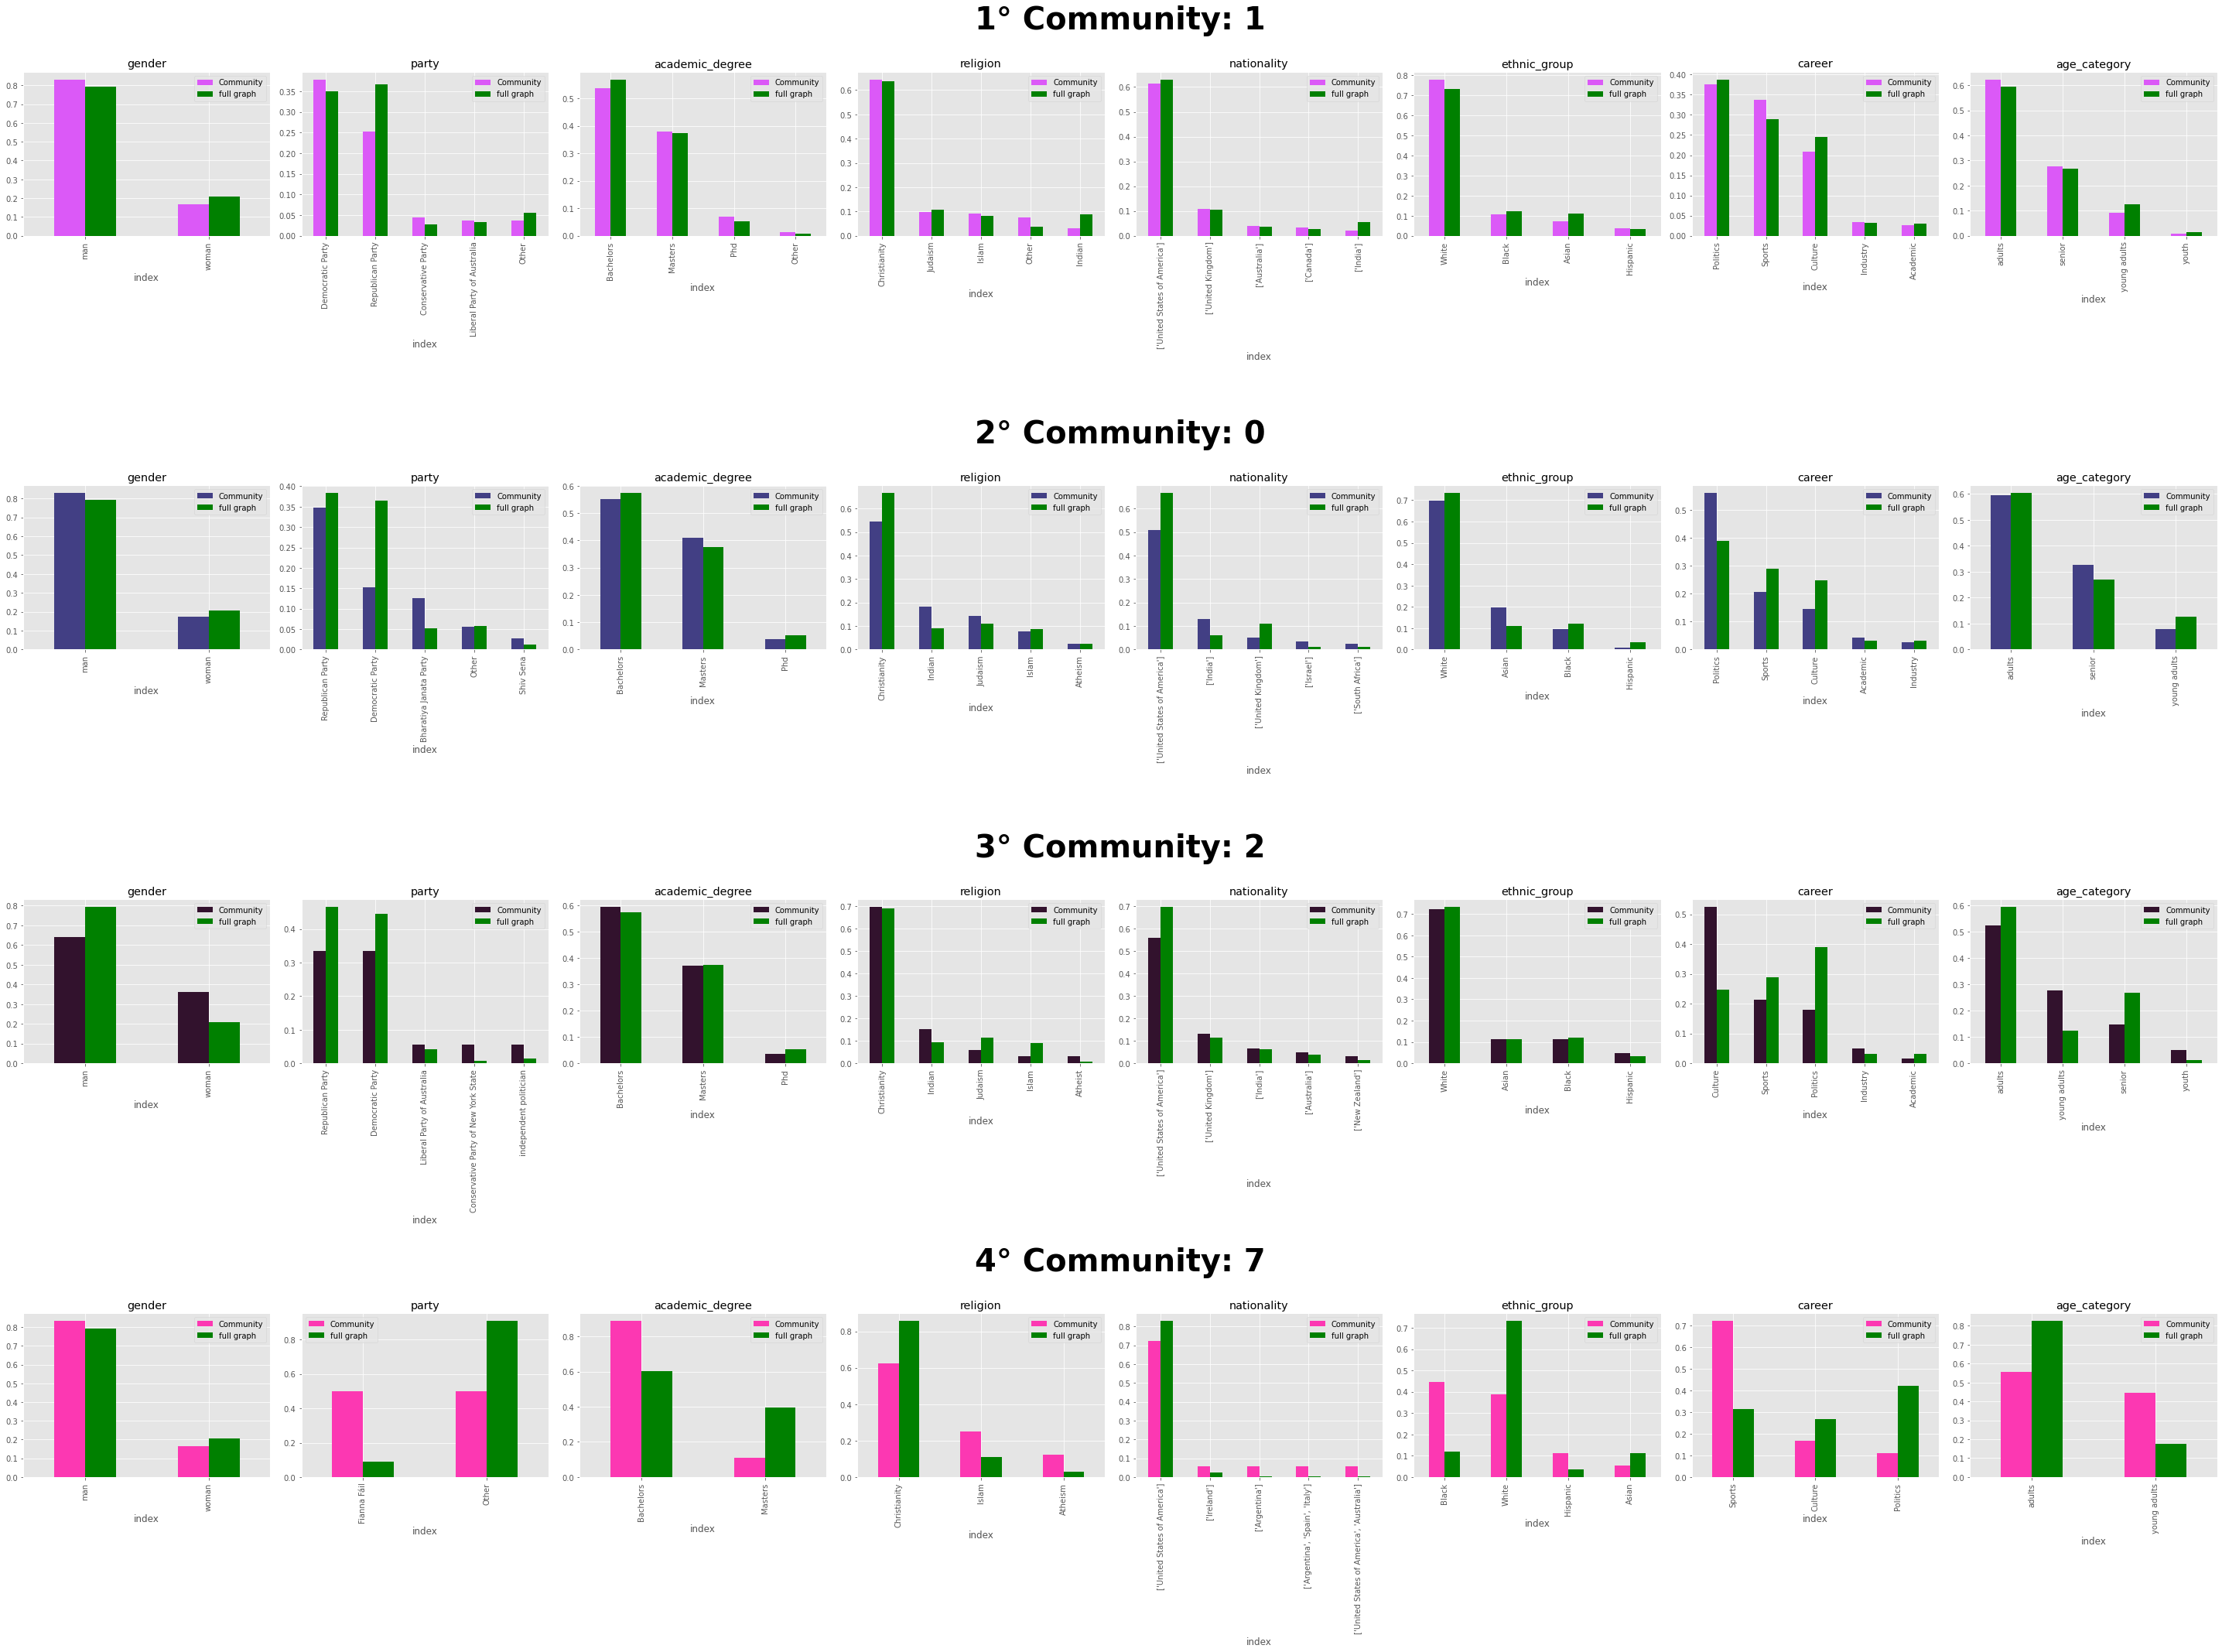

In [ ]:
# We select the 4 largest communities 
nbr_of_communities = 4
top_communities_list = top_communities(popularity_add_features_top_500_with_communities, nbr_of_communities)

# We compute the statistics on the 4 communities  
community_statistics(popularity_add_features_top_500_with_communities, top_communities_list)

The 4 communities contain 91,82% of the graph. It seems that we identify: 

1.   Community 1: Democratic community 
2.   Community 0: Republican community 
3.Community 2: Culture community
4.Community 7: Sport/Black community


#### 7.4.3. Where are they ? 

Let's check if our communities make sense. We will see to what community do well-known person sush as Trump, Biden, Messi or Harry Potter and many more belong to!

In [ ]:
political_names_1 = ["Donald Trump", "Vladimir Putin", "Xi Jinping", "Kim Jong-un","Narendra Modi", "Boris Johnson","Mike Pompeo","Ted Cruz","Mike Pence","Robert Mueller","Melania Trump"]
political_names_2 = ["Hillary Clinton", "Bernie Sanders", "Emmanuel Macron", "Joe Biden","Barack Obama","Nancy Pelosi"]
industry_names= ["Harry Potter", "Chris Harrison", "Kim Kardashian", "Taylor Swift","Harry Styles","Justin Bieber","Cardi B"]
business_names = ["Jeff Bezos", "Elon Musk", "Mark Cuban"]
sport_names = ["LeBron James","Kobe Bryant", "Roger Federer",'Lionel Messi','Conor McGregor',"Stephen Curry"]

full_list = [political_names_1,political_names_2,industry_names,business_names,sport_names]

for name_group in full_list:
  print("\n")
  for name in name_group :
    show_communities = popularity_add_features_top_500_with_communities[popularity_add_features_top_500_with_communities.label == name]
    print("{} is in the community {}.".format(name, show_communities.modularity_class.iloc[0]))




Donald Trump is in the community 0.
Vladimir Putin is in the community 1.
Xi Jinping is in the community 1.
Kim Jong-un is in the community 0.
Narendra Modi is in the community 0.
Boris Johnson is in the community 1.
Mike Pompeo is in the community 1.
Ted Cruz is in the community 8.
Mike Pence is in the community 0.
Robert Mueller is in the community 0.
Melania Trump is in the community 0.


Hillary Clinton is in the community 1.
Bernie Sanders is in the community 1.
Emmanuel Macron is in the community 1.
Joe Biden is in the community 1.
Barack Obama is in the community 1.
Nancy Pelosi is in the community 1.


Harry Potter is in the community 2.
Chris Harrison is in the community 2.
Kim Kardashian is in the community 2.
Taylor Swift is in the community 2.
Harry Styles is in the community 2.
Justin Bieber is in the community 1.
Cardi B is in the community 2.


Jeff Bezos is in the community 1.
Elon Musk is in the community 1.
Mark Cuban is in the community 8.


LeBron James is in the 

### 7.5. Find most influential features in each community

We will conduct a analysis of each feature to see which one is the most influential regarding communities (Chi-Squared and mutual information).

In [ ]:
# Encoding categorical values to int

# Encode string values to integer for X (e.g: 'Q22831' -> 2)
def encode_X(X):
  oe = OrdinalEncoder()
  oe.fit(X)
  X_enc = oe.transform(X)
  return X_enc

# Encode string values to integer for y (e.g: 'Q22831' -> 2)
def encode_y(y):
  le=LabelEncoder()
  le.fit(y)
  y_enc=le.transform(y)
  return y_enc

def one_hot_encode_X(X):
  enc = OneHotEncoder(handle_unknown='ignore')
  enc.fit(X)
  X_one_hot=enc.transform(X)
  return  X_one_hot,enc

In [ ]:
# Load data
df_community=popularity_add_features_top_500_with_communities.drop(columns=['id', 'label'])

# Set features and label
features=['gender', 'nationality','party','academic_degree','religion','ethnic_group','age_category','career']
label=['modularity_class']

for feature in features:
  # Explode list value in features into single rows with respective element in list
  df_community=df_community.explode(feature).reset_index(drop=True)

# Define X,y
X=df_community[features]
y=df_community[label]

X=X.astype(str)

# X,y encoding
X=encode_X(X)
y=encode_y(y)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


###### 7.4.4.1. Chi-Squared

Using Chi-Squared scores is a good way to determine the importance of features. 

Feature 0-gender: 22.7
Feature 1-nationality: 125.36
Feature 2-party: 59.18
Feature 3-academic_degree: 11.75
Feature 4-religion: 15.3
Feature 5-ethnic_group: 11.37
Feature 6-age_category: 21.02
Feature 7-career: 51.54


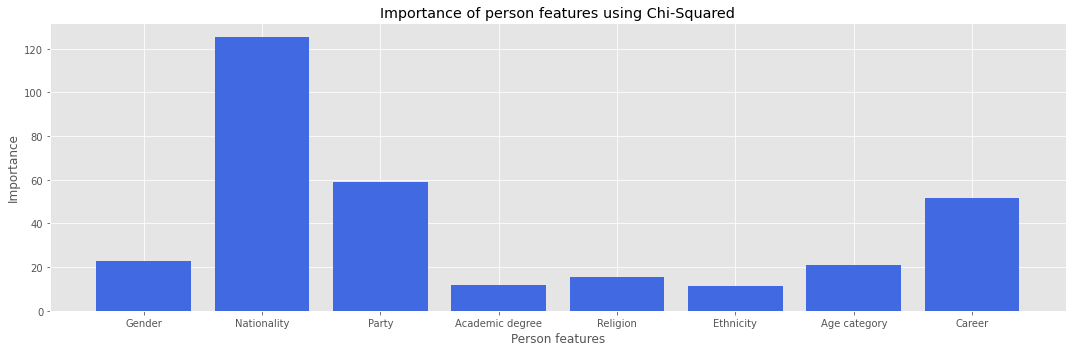

In [ ]:
fs = SelectKBest(score_func=chi2, k='all')
fs.fit(X, y)
X = fs.transform(X)
# What are scores for the features
for i in range(len(fs.scores_)):
	print(f'Feature {i}-{features[i]}: {round(fs.scores_[i],2)}')
# Plot the scores

LABELS = ["Gender", "Nationality", "Party","Academic degree", "Religion", "Ethnicity", "Age category", "Career"]
plt.bar([i for i in range(len(fs.scores_))], fs.scores_,color="royalblue")
plt.xticks([i for i in range(len(fs.scores_))], LABELS)
plt.xlabel("Person features")
plt.ylabel("Importance")
plt.title("Importance of person features using Chi-Squared")
plt.savefig(path_to_figures + "features_chi_squared.png")
plt.show()

## 8. Bonus : Community detection for 2015-2020 (all years combined)

In this section we re-run the section 7 but with the quotes of all the years 2015-2020 combined rather than 2020. The functions of section 7 are being used in this section. 

### 8.0. Load the data : all years 2015-2020

In [ ]:
# Load graph_top_500 and keep all the years 
graph_top_500 = pd.read_csv(path_to_graph_top_500)
graph_top_500 = graph_top_500.drop("year",axis=1)

### 8.1. Parallel edges removal 

In [ ]:
# Show number of parallel edges (i.e edges that link the same 2 node multiple times in the same direction)
graph_parallel_edges=graph_top_500.groupby(['mention_id','speaker_id'],as_index=False).size()
graph_parallel_edges=graph_parallel_edges.rename(columns={"size":"nbr_parallel_edges"})
num_nodes_parallel_edges=graph_parallel_edges[graph_parallel_edges["nbr_parallel_edges"]>1].shape[0]

In [ ]:
# Aggregate parallel edges and average their compound score
graph_top_500=graph_top_500.groupby(['mention_id','speaker_id'])['compound_score'].mean().reset_index()

# Add number of parallel edges to graph_top_500
graph_top_500=graph_top_500.join(graph_parallel_edges.set_index(['mention_id', 'speaker_id']), on=['mention_id', 'speaker_id'], how='inner')

# Recompute compound
graph_top_500['compound_score']=graph_top_500.apply(lambda x: recompute_compound(x['compound_score'], x['nbr_parallel_edges']), axis=1)

# Compute distance
graph_top_500['distance']=graph_top_500.apply(lambda x: distance_parallel(x['compound_score']), axis=1)

### 8.2. Create .csv for gephi

In [ ]:
# Adapt graph_top_500 in order to be processable by gephi
graph_gephi_all_years=graph_top_500.drop(columns=['compound_score'])
graph_gephi_all_years=graph_gephi_all_years.rename(columns={"speaker_id": "Source", "mention_id": "Target", "distance":"Weight"})
graph_gephi_all_years=graph_gephi_all_years[['Source','Target','Weight']]

# Save graph_gephi and process it on gephi
graph_gephi_all_years.to_csv(path_to_graph_gephi_all_years, index=False)

### 8.3. Result of gephi

In [ ]:
# Load the result of gephi : modularity file
graph_modularity_all_years=pd.read_csv("/content/drive/MyDrive/Data/graph_modularity_all_years.csv",sep=";")
graph_modularity_all_years=graph_modularity_all_years.drop(columns=['timeset','Label'])

# Show result 
graph_modularity_all_years.head(5)

,Id,modularity_class
0,Q1000592,0
1,Q11668,0
2,Q16728747,2
3,Q1758777,4
4,Q230733,7


In [ ]:
# Remove unwanted columns
graph_modularity_all_years=graph_modularity_all_years[['Id', 'modularity_class']]
# Rename Id to id
graph_modularity_all_years=graph_modularity_all_years.rename(columns={'Id':'id'})

# Print number of communities
communities=graph_modularity_all_years['modularity_class'].unique()
print(f'Communities are {communities}')

Communities are [0 2 4 7 6 1 5 3]


In [ ]:
# Add community to  each ids in popularity_add_features_top_500
popularity_add_features_top_500_all_years_with_communities = popularity_add_features_top_500[['id','age','label','gender','party','academic_degree','religion','nationality','ethnic_group','career']].join(graph_modularity_all_years.set_index('id'), on='id', how='inner')
popularity_add_features_top_500_all_years_with_communities.head(5)

,id,age,label,gender,party,academic_degree,religion,nationality,ethnic_group,career,modularity_class
0,Q22686,74.0,Donald Trump,1,Republican Party,Bachelors,Christianity,['United States of America'],White,Politics,0
1,Q6294,73.0,Hillary Clinton,0,Democratic Party,Bachelors,Christianity,['United States of America'],White,Politics,7
2,Q6279,78.0,Joe Biden,1,Democratic Party,Masters,Christianity,['United States of America'],White,Politics,5
3,Q76,59.0,Barack Obama,1,Democratic Party,Bachelors,Christianity,['United States of America'],Black,Politics,7
4,Q359442,79.0,Bernie Sanders,1,Liberty Union Party,Bachelors,Judaism,['United States of America'],White,Politics,7


### 8.4. Analysis of the communities

### 8.4.1. Create age bins and change gender label

In [ ]:
# Create categories for age
def conditions(age):
    if 0<=age<=14 :
      return "children"  
    if 15<=age<=24:
      return "youth"  
    if 25<=age<=35:
      return "young adults"
    if 36<=age<=64:
      return "adults"
    if 65<=age:
      return "senior"
      
func = np.vectorize(conditions)
popularity_add_features_top_500_all_years_with_communities['age_category'] = func(popularity_add_features_top_500_all_years_with_communities["age"])
popularity_add_features_top_500_all_years_with_communities = popularity_add_features_top_500_all_years_with_communities.drop(columns=["age"],axis =1) 

# Replace gender column : 1 and 0 by men and women
popularity_add_features_top_500_all_years_with_communities['gender'] = np.where(popularity_add_features_top_500_all_years_with_communities['gender']==1, "man","woman")

### 8.4.2. Compute statistics and plot distribution with histogram

-----------------COMMUNITY 7----------------
There is 194 of person, which represents 41.28% of the graph.
The most common value for gender is man.
The most common value for party is Democratic Party.
The most common value for academic_degree is Bachelors.
The most common value for religion is Christianity.
The most common value for nationality is ['United States of America'].
The most common value for ethnic_group is White.
The most common value for career is Politics.
The most common value for age_category is adults.
-----------------COMMUNITY 0----------------
There is 128 of person, which represents 27.23% of the graph.
The most common value for gender is man.
The most common value for party is Republican Party.
The most common value for academic_degree is Bachelors.
The most common value for religion is Christianity.
The most common value for nationality is ['United States of America'].
The most common value for ethnic_group is White.
The most common value for career is Politics.


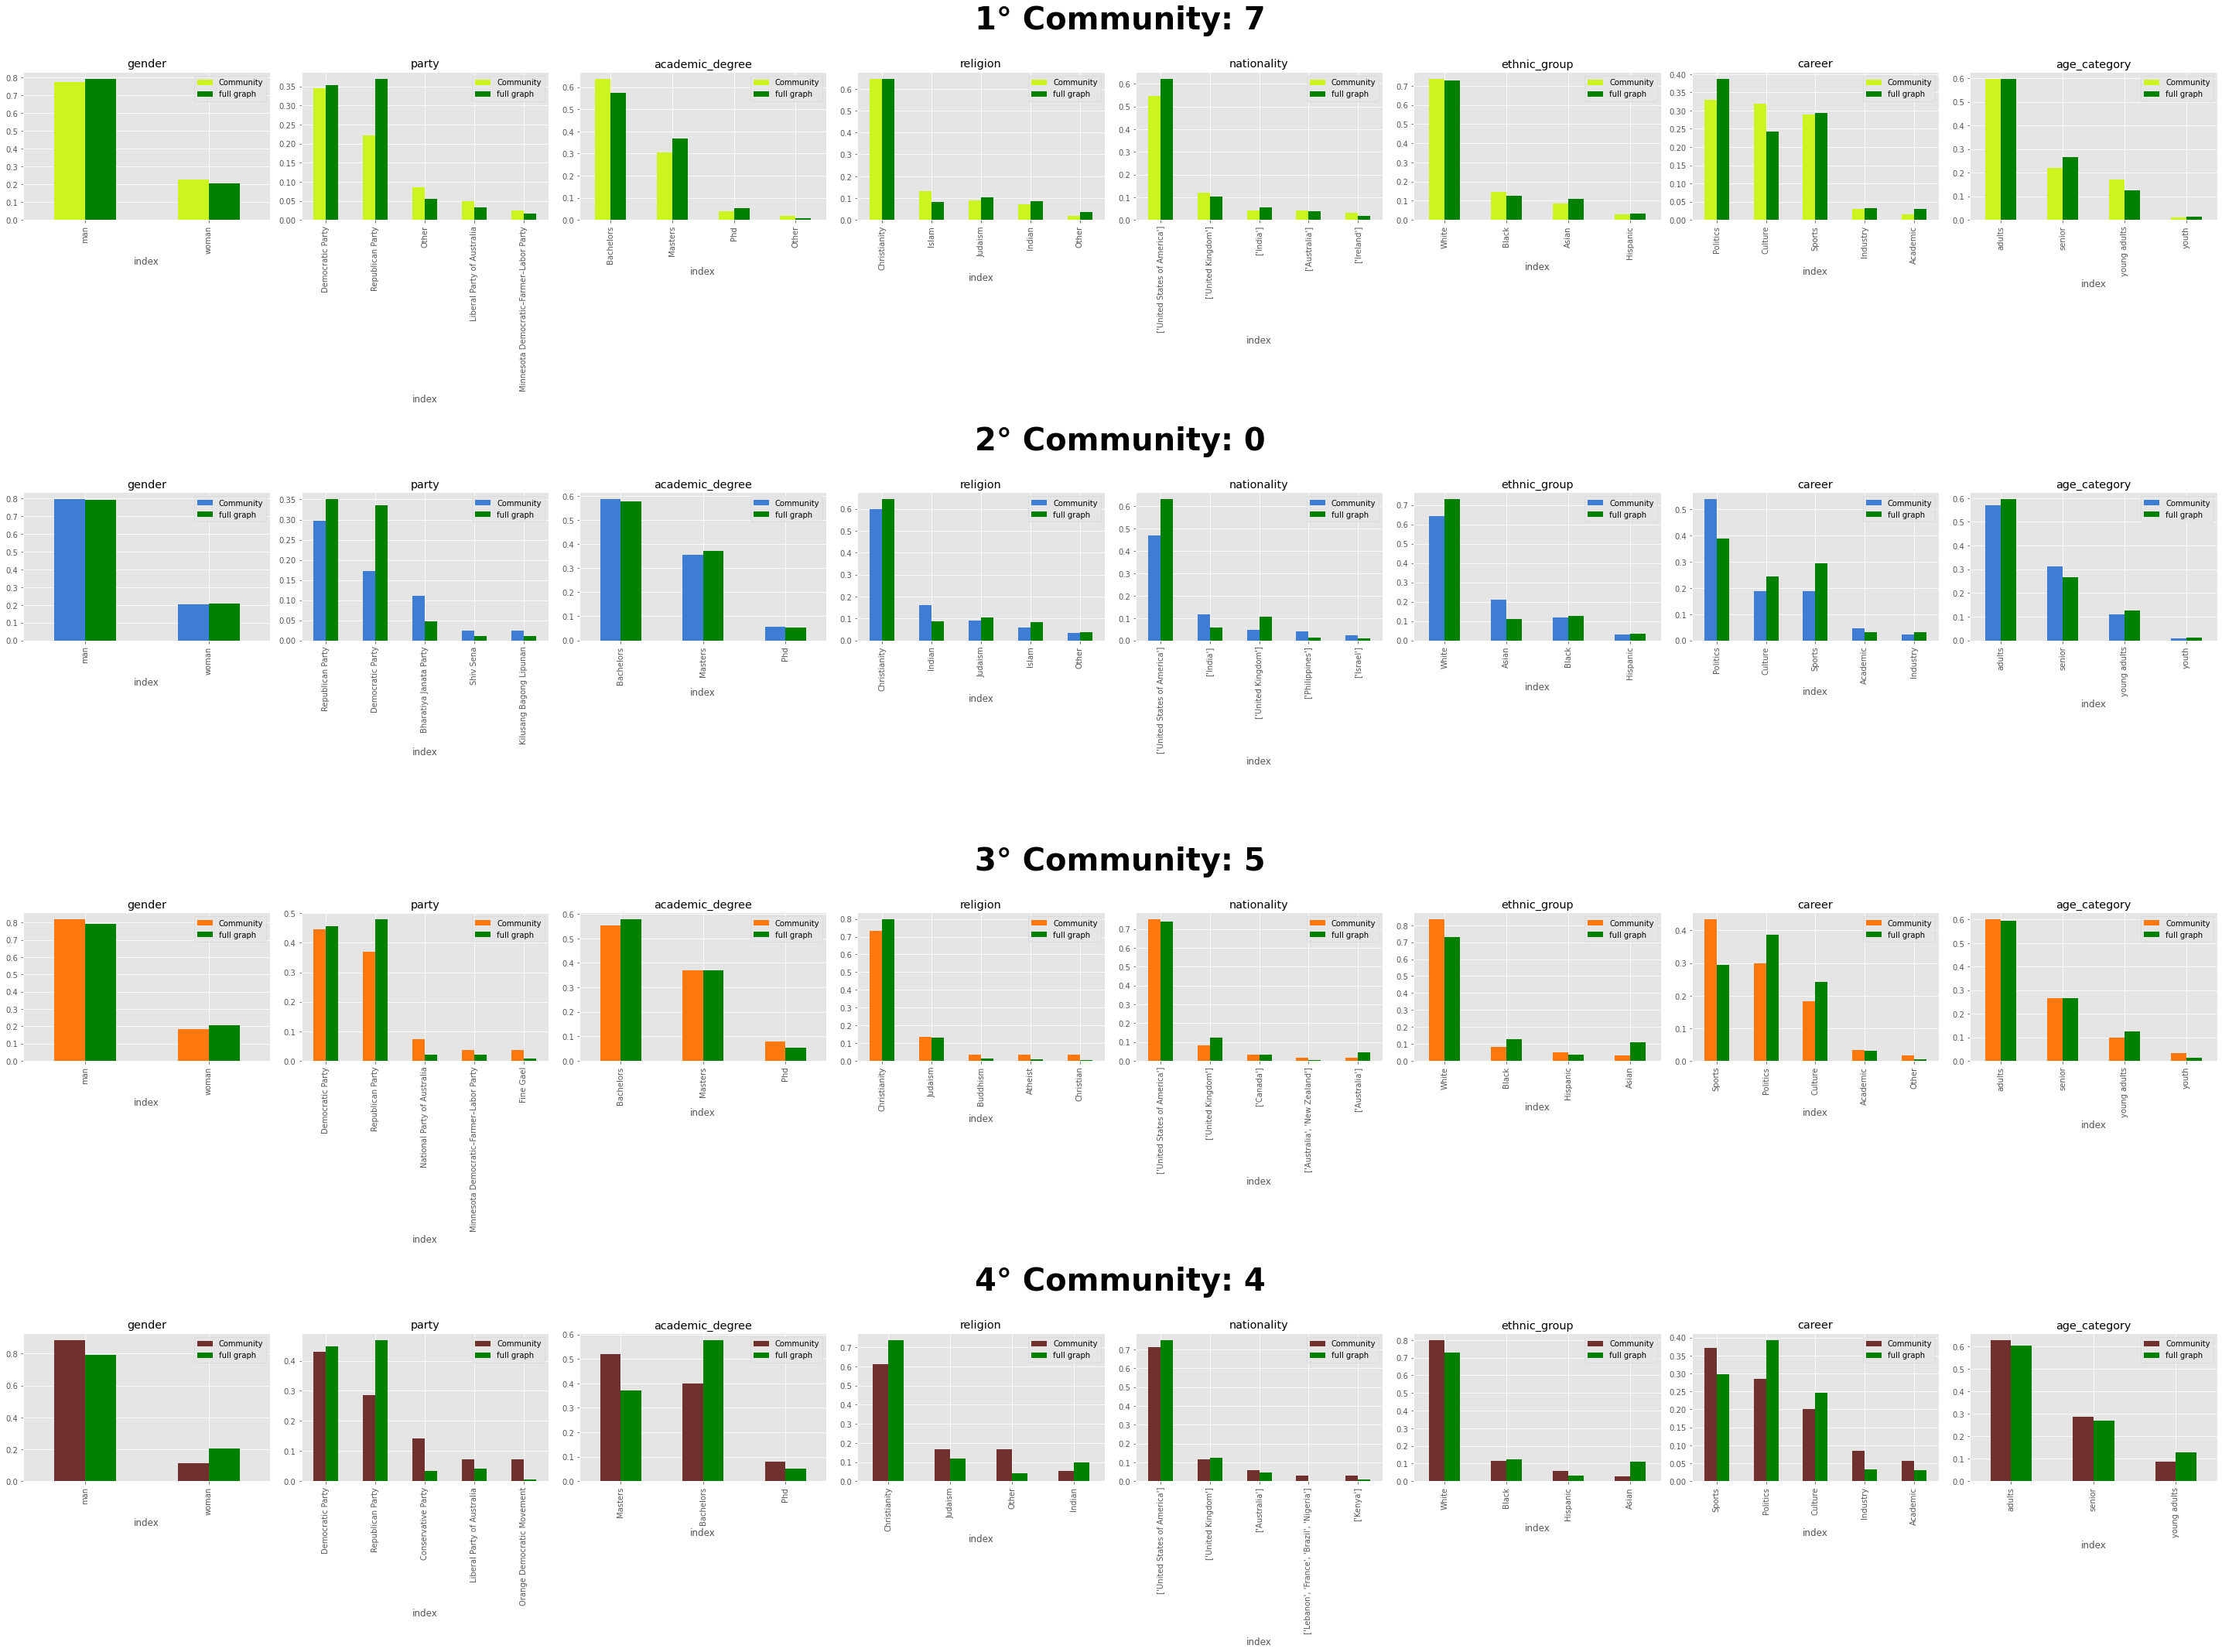

In [ ]:
# We select the 4 largest communities 
nbr_of_communities = 4
top_communities_list = top_communities(popularity_add_features_top_500_all_years_with_communities, nbr_of_communities)

# We compute the statistics on the 4 communities  
community_statistics(popularity_add_features_top_500_all_years_with_communities, top_communities_list)

The 4 communities contain 88,58% of the graph. It seems that we identify: 

1.   Community 7 : Democratic/politics community 
2.   Community 0 : Republican/politics community 
3.Community 5 : Sport community
4.Community 4 : Sport/educated (high % masters) community

### 8.4.3. Where are they ? 

In [ ]:
political_names_1 = ["Donald Trump", "Vladimir Putin", "Xi Jinping", "Kim Jong-un","Narendra Modi", "Boris Johnson","Mike Pompeo","Ted Cruz","Mike Pence","Robert Mueller","Melania Trump"]
political_names_2 = ["Hillary Clinton", "Bernie Sanders", "Emmanuel Macron", "Joe Biden","Barack Obama","Nancy Pelosi"]
industry_names= ["Harry Potter", "Chris Harrison", "Kim Kardashian", "Taylor Swift","Harry Styles","Justin Bieber","Cardi B"]
business_names = ["Jeff Bezos", "Elon Musk", "Mark Cuban"]
sport_names = ["LeBron James","Kobe Bryant", "Roger Federer",'Lionel Messi','Conor McGregor',"Stephen Curry"]

full_list = [political_names_1,political_names_2,industry_names,business_names,sport_names]

for name_group in full_list:
  print("\n")
  for name in name_group :
    show_communities = popularity_add_features_top_500_all_years_with_communities[popularity_add_features_top_500_all_years_with_communities.label == name]
    print("{} is in the community {}.".format(name, show_communities.modularity_class.iloc[0]))



Donald Trump is in the community 0.
Vladimir Putin is in the community 0.
Xi Jinping is in the community 0.
Kim Jong-un is in the community 0.
Narendra Modi is in the community 0.
Boris Johnson is in the community 0.
Mike Pompeo is in the community 0.
Ted Cruz is in the community 0.
Mike Pence is in the community 0.
Robert Mueller is in the community 3.
Melania Trump is in the community 0.


Hillary Clinton is in the community 7.
Bernie Sanders is in the community 7.
Emmanuel Macron is in the community 0.
Joe Biden is in the community 5.
Barack Obama is in the community 7.
Nancy Pelosi is in the community 0.


Harry Potter is in the community 7.
Chris Harrison is in the community 4.
Kim Kardashian is in the community 0.
Taylor Swift is in the community 7.
Harry Styles is in the community 7.
Justin Bieber is in the community 7.
Cardi B is in the community 7.


Jeff Bezos is in the community 7.
Elon Musk is in the community 0.
Mark Cuban is in the community 4.


LeBron James is in the 